### [목차]
1) 전처리 (msno-> 결측값, 이상값 처리 ==> 머신러닝 위한 준비단계)  
2) 시각화  
3) Train/Test set 구분 (7:3, random_state=13, stratify="Brand")  
4) Pipeline 구축, 모델링  
5) 최적 모델 찾기

## 1) 전처리

In [1]:
# Import 및 데이터 불러오기
import plotly.express as px
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
usedcar_origin = pd.read_csv("datas/train-data.csv", index_col=0)

In [2]:
usedcar_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


### 결측값 처리

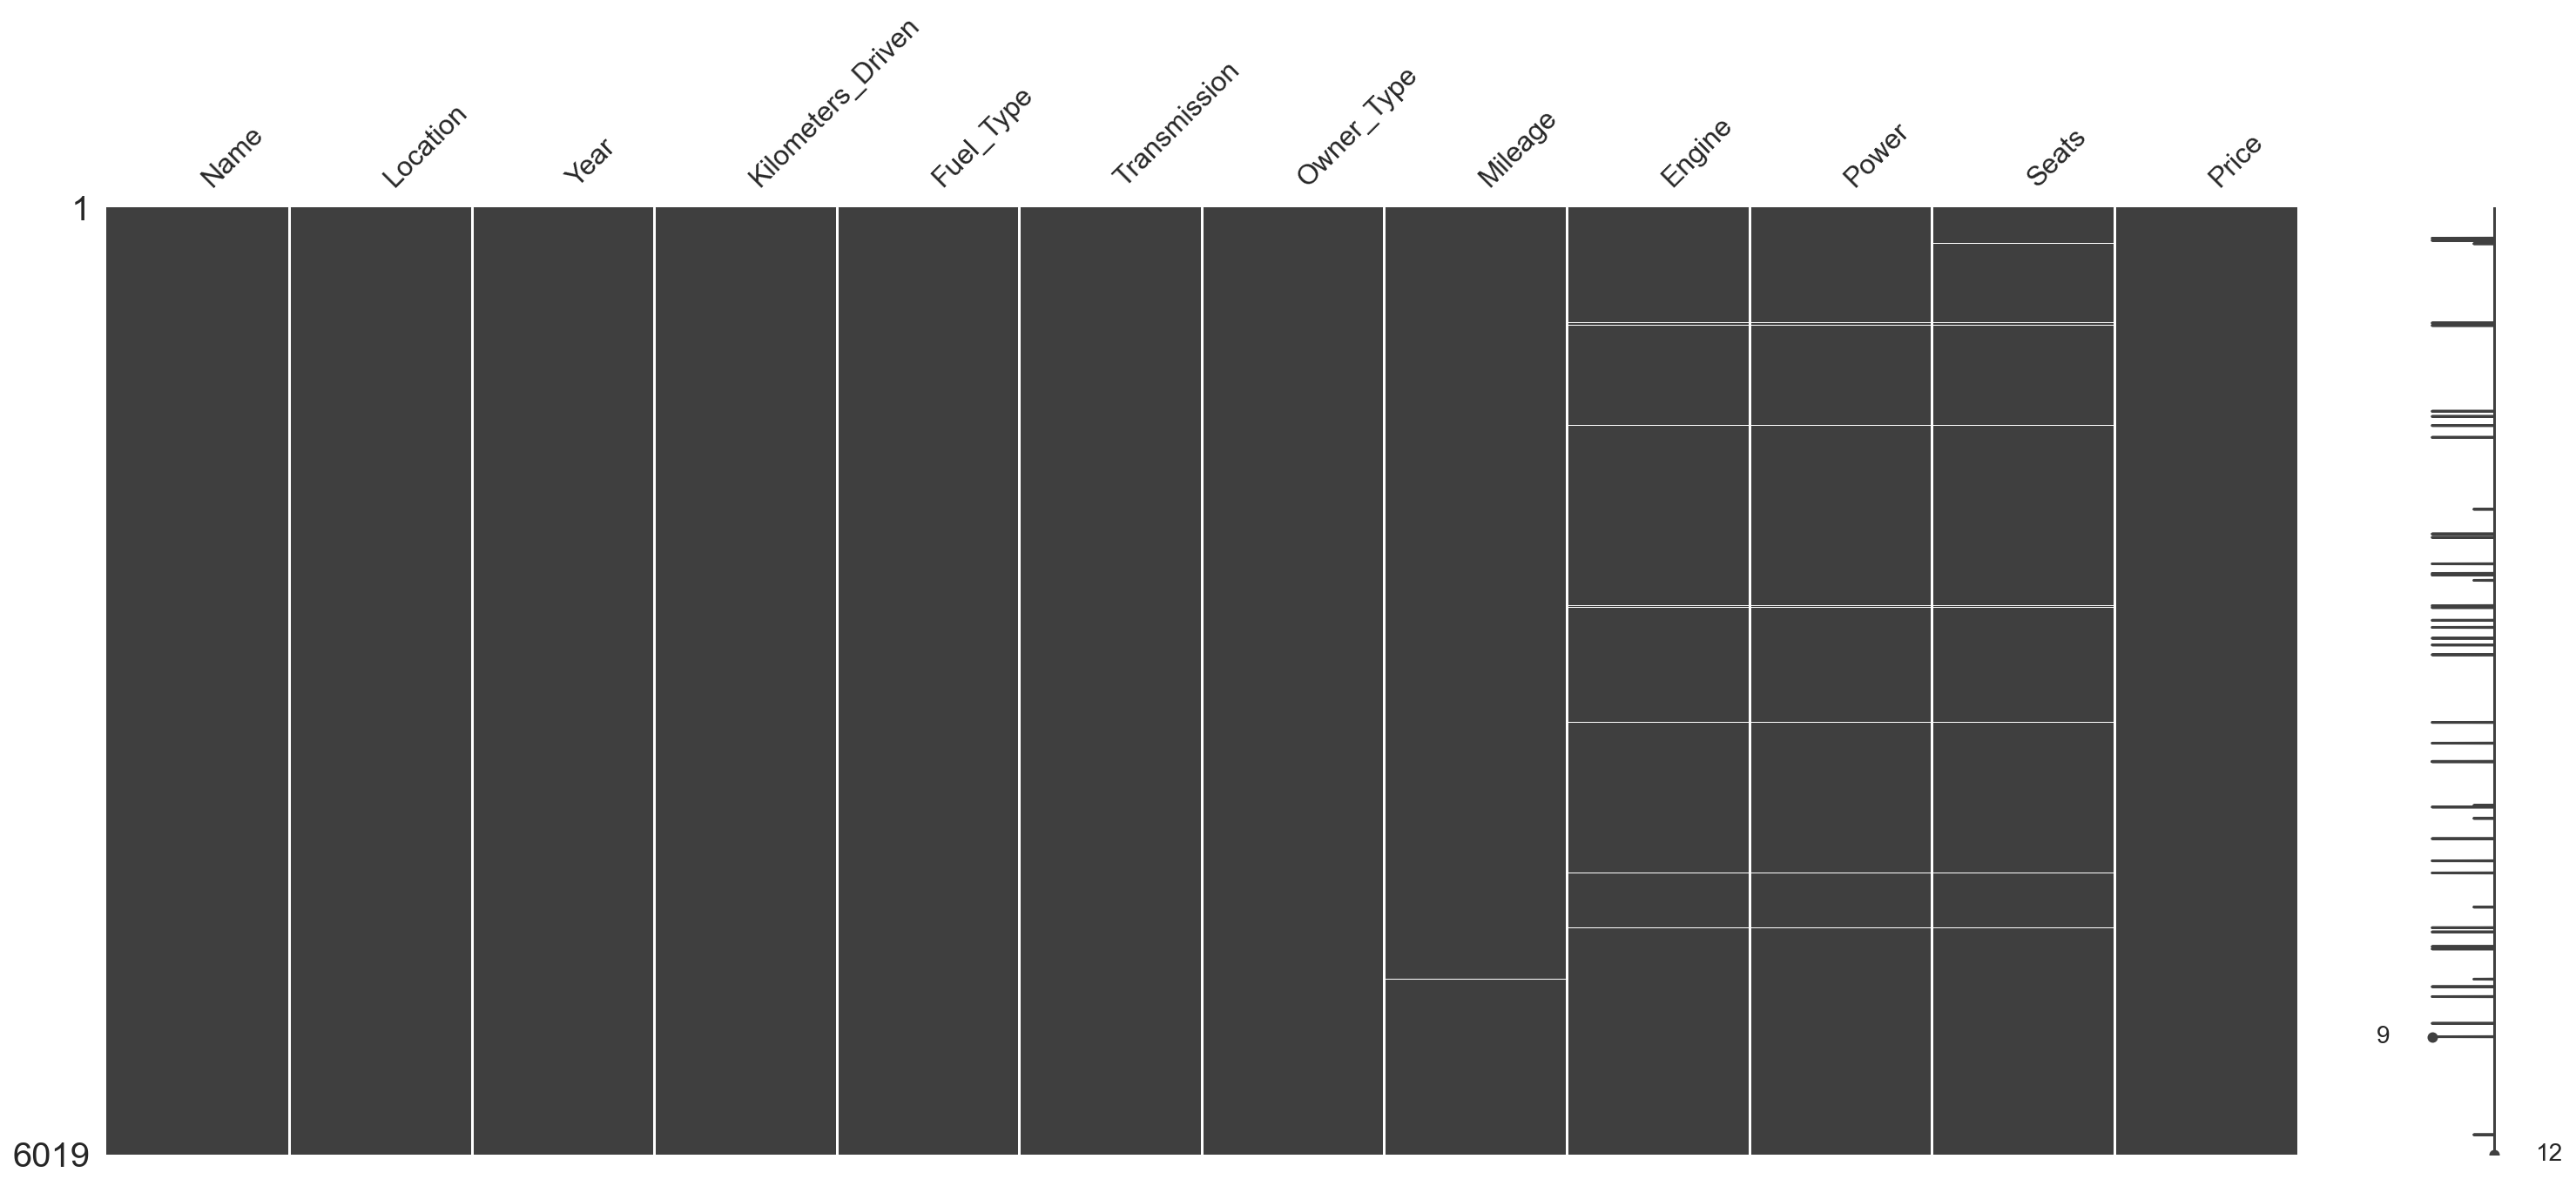

In [3]:
# New_price는 drop
usedcar_origin.drop('New_Price', axis=1, inplace=True)
msno.matrix(usedcar_origin);

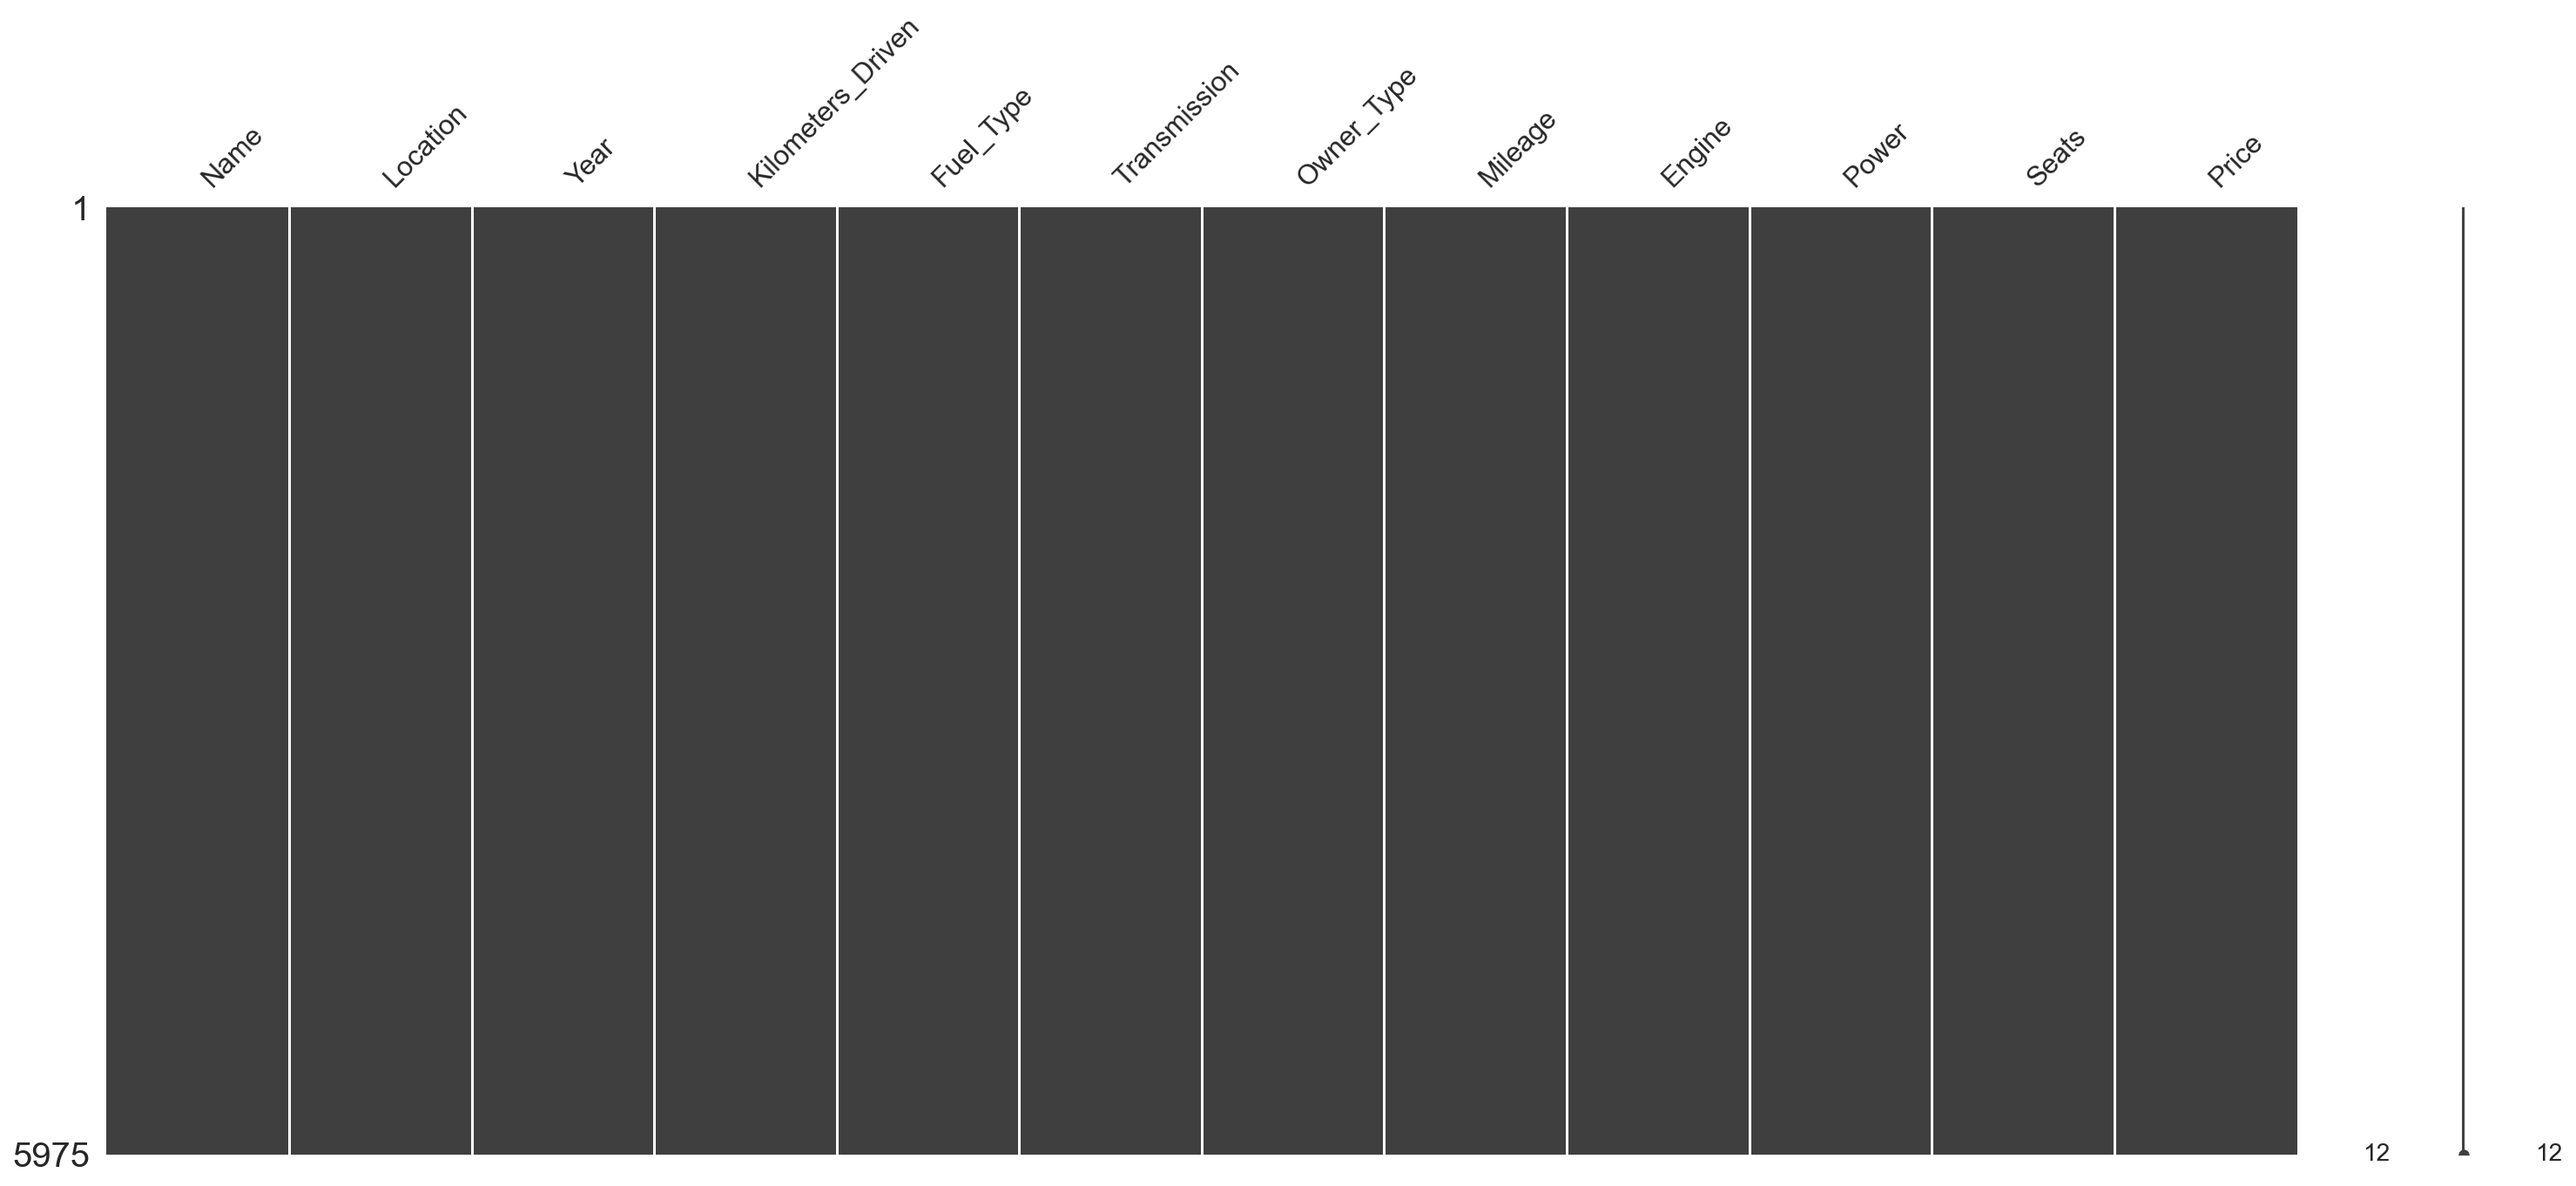

In [4]:
# 44/6019 = 0.7%. 적은 부분이라 결측값 44개는 삭제 결정
usedcar_origin.dropna(inplace=True)
msno.matrix(usedcar_origin);

In [5]:
# 이제 다 5975개 non-null
usedcar_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5975 non-null   object 
 1   Location           5975 non-null   object 
 2   Year               5975 non-null   int64  
 3   Kilometers_Driven  5975 non-null   int64  
 4   Fuel_Type          5975 non-null   object 
 5   Transmission       5975 non-null   object 
 6   Owner_Type         5975 non-null   object 
 7   Mileage            5975 non-null   object 
 8   Engine             5975 non-null   object 
 9   Power              5975 non-null   object 
 10  Seats              5975 non-null   float64
 11  Price              5975 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 606.8+ KB


### 형변환, 'power'열값 대치

In [6]:
# Mileage, Engine, Power 숫자화
# 우선 2개 (Mileage, Engine)부터 숫자화
# Mileage
usedcar_origin["Mileage"] = usedcar_origin["Mileage"].str.split(" ", expand=True)[0].str.strip().astype(float)
# Engine
usedcar_origin["Engine"] = usedcar_origin["Engine"].str.split(" ", expand=True)[0].str.strip().astype(float)

In [7]:
# Power 숫자화
# 'null'이 103개 행 -> 단순 삭제보다는 활용할 수 있으면 하는 게 좋다고 판단
# 103행이지만 고유값은 27개 -> power가 0인 값들의 engine을 보면 최대최소값 차이가 커서 mean이나 median같은 단일값보다
# 상관관계가 0.9 수준인 Engine값을 통한 추정값을 넣는 게 낫다고 판단
# 둘 간에 회귀분석 모델링

# 추후 그냥 제거/mean/median 넣고도 돌려볼 예정

In [8]:
# Power도 일단 단위부터 떼어내기
usedcar_origin["Power"] = usedcar_origin["Power"].str.split(" ", expand=True)[0].str.strip()

<AxesSubplot:>

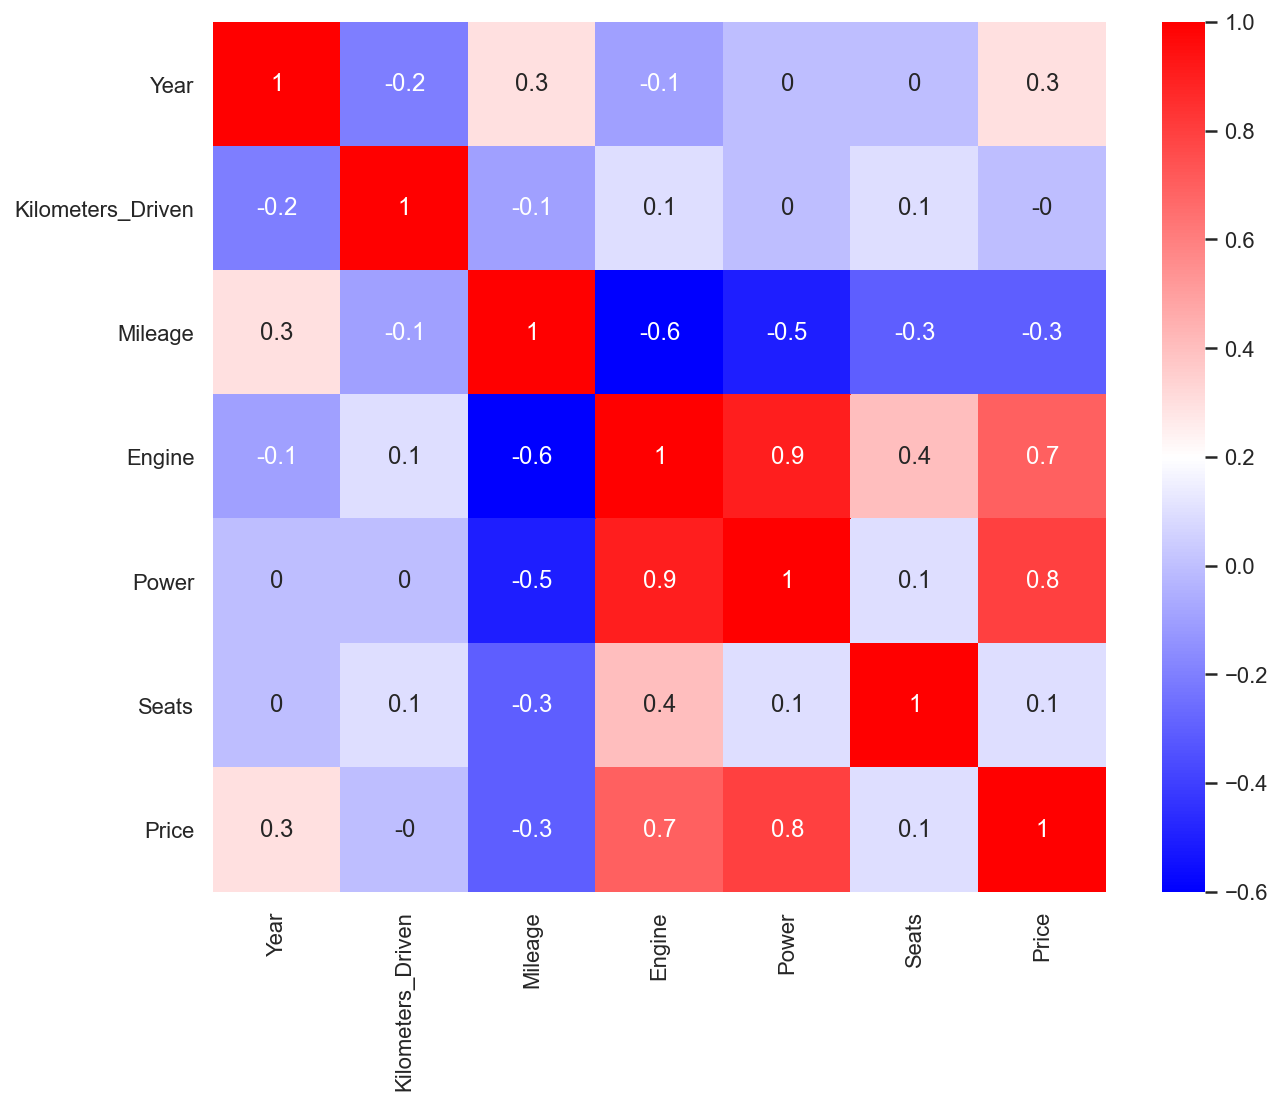

In [9]:
# null 제거하고 컬럼별 상관관계 보기
usedcar_origin_null = usedcar_origin[~usedcar_origin.Power.str.contains("null")]
usedcar_origin_null["Power"] = usedcar_origin_null["Power"].astype("float")
corr_mat = usedcar_origin_null.corr().round(1)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data=corr_mat, annot=True, cmap='bwr')

In [10]:
# 간단히 회귀분석으로 power==null인 데이터 대치
# train data의 power~engine rmse=26.9 (ref. tmp1['power'] std=53.8)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


tmp1 = usedcar_origin[~(usedcar_origin["Power"] == "null")]
tmp2 = usedcar_origin[(usedcar_origin["Power"] == "null")]
tmp1["Power"] = tmp1["Power"].astype(float)


lr = LinearRegression()
lr.fit(X=tmp1[["Engine"]], y=tmp1[["Power"]])
rmse =np.sqrt(mean_squared_error(tmp1[["Power"]], lr.predict(tmp1[["Engine"]])))
print(rmse)


# power가 null었던 부분에 예측값으로 대체
usedcar_origin.loc[(usedcar_origin["Power"].str.split(" ", expand=True)[0].str.strip() == "null"), "Power"] = \
lr.predict(tmp2[["Engine"]])


# Power도 새로 들어온 데이터 위해 다시 형변환
usedcar_origin["Power"] = usedcar_origin["Power"].astype(float)

26.912935568392896


In [11]:
# null값 채우고 형변환 완료!
usedcar_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5975 non-null   object 
 1   Location           5975 non-null   object 
 2   Year               5975 non-null   int64  
 3   Kilometers_Driven  5975 non-null   int64  
 4   Fuel_Type          5975 non-null   object 
 5   Transmission       5975 non-null   object 
 6   Owner_Type         5975 non-null   object 
 7   Mileage            5975 non-null   float64
 8   Engine             5975 non-null   float64
 9   Power              5975 non-null   float64
 10  Seats              5975 non-null   float64
 11  Price              5975 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 606.8+ KB


### 이상치 확인

Text(0.5, 1.0, 'Price')

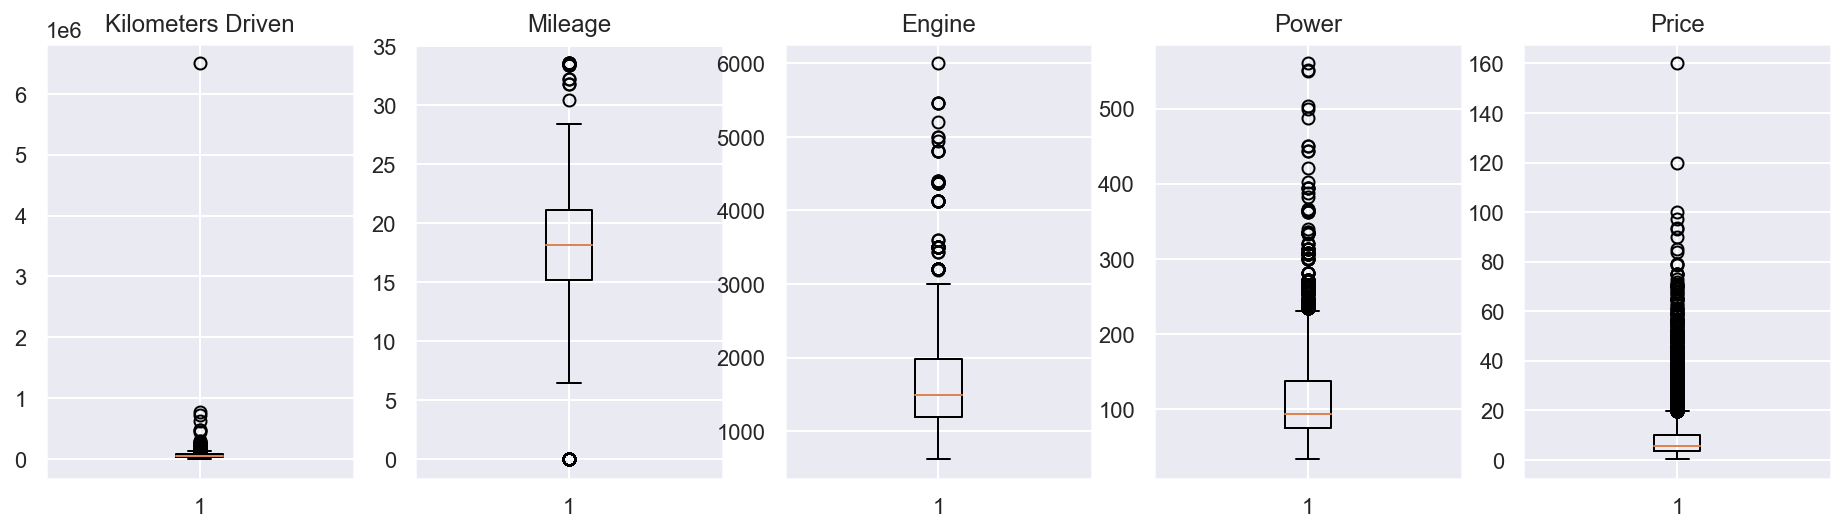

In [12]:
# Kilometers_Driven 이상치 제거하고 boxplot 확인~ 아까보단 낫군..
fig, ax = plt.subplots(1,5, figsize=(16,4))

ax[0].boxplot(usedcar_origin.Kilometers_Driven)
ax[0].set_title("Kilometers Driven")

ax[1].boxplot(usedcar_origin.Mileage)
ax[1].set_title("Mileage")

ax[2].boxplot(usedcar_origin.Engine)
ax[2].set_title("Engine")

ax[3].boxplot(usedcar_origin.Power)
ax[3].set_title("Power")

ax[4].boxplot(usedcar_origin.Price)
ax[4].set_title("Price")

### 이상치 처리 (제거, 대치, 유지)

In [13]:
# 일단 null 처리했으니, null은 아니나 우수한 학습 위해 제거해야 할 데이터 여부 확인
# -> (1) Mileage min=0, (2) Seats min=0,
# (3) Kilometers_Driven, (4) Price max 너무 아웃라이어
# 확인 후 필요 시 전처리 조치 취해야겠다.
# Brand열은 이후에 추가 예정
usedcar_origin.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,5975.000000,5.975000e+03,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000
mean,2013.386778,5.867431e+04,18.179408,1621.606695,112.955782,5.278828,9.501647
std,3.247238,9.155851e+04,4.521801,601.036987,53.725132,0.808959,11.205736
min,1998.000000,1.710000e+02,0.000000,624.000000,34.200000,0.000000,0.440000
25%,2012.000000,3.390800e+04,15.200000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.160000,1493.000000,93.700000,5.000000,5.650000
75%,2016.000000,7.300000e+04,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


In [14]:
# (1) Mileage -> 56개 데이터. 우선 삭제. 추후 대체값 채워서 재학습 예정
usedcar_origin[usedcar_origin["Mileage"]==0.0].describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,56.000000,56.000000,56.0,56.000000,56.000000,56.000000,56.000000
mean,2009.410714,73994.017857,0.0,1763.303571,114.706444,5.125000,11.925714
std,4.670125,47859.011314,0.0,825.287717,57.852234,0.895697,15.398214
min,2001.000000,4000.000000,0.0,799.000000,49.134459,2.000000,0.550000
25%,2006.000000,45875.000000,0.0,1086.000000,64.651309,5.000000,1.435000
50%,2009.000000,66500.000000,0.0,1164.000000,77.452710,5.000000,2.615000
75%,2012.000000,90000.000000,0.0,2245.750000,165.000000,5.000000,18.875000
max,2019.000000,227000.000000,0.0,3597.000000,262.600000,10.000000,49.240000


In [15]:
usedcar_origin = usedcar_origin[usedcar_origin["Mileage"]!=0]

In [16]:
# (2) Seats
# Seats가 0인게 하나 있다 -> 직접 구글링해서 5인승인거 찾아내서 대체
usedcar_origin.loc[usedcar_origin["Seats"]==0, "Seats"] = 5.0

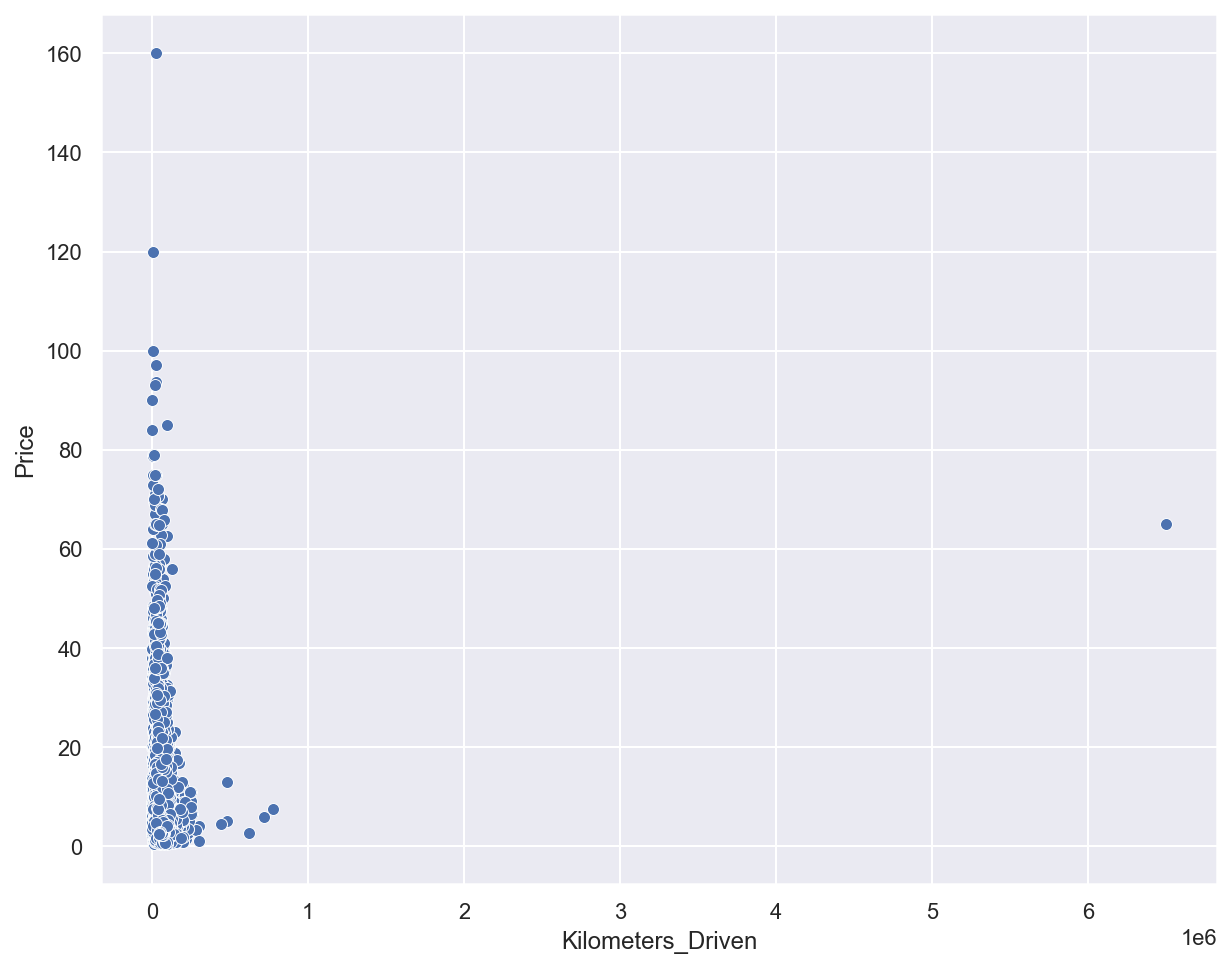

In [17]:
# (3) Kilometers_Driven
# 600만km가 넘는다? 자세히 더 살펴보자
sns.scatterplot(x=usedcar_origin.Kilometers_Driven, y=usedcar_origin.Price);

In [18]:
# 최신 2019년식일 때 2017년식인데 650만 km..?
# 이정도면 시속 240이상으로 24시간 3년 달려야하는거리.. 말이 안됨. 삭제~
usedcar_origin[usedcar_origin["Kilometers_Driven"]>=6000000]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,65.0


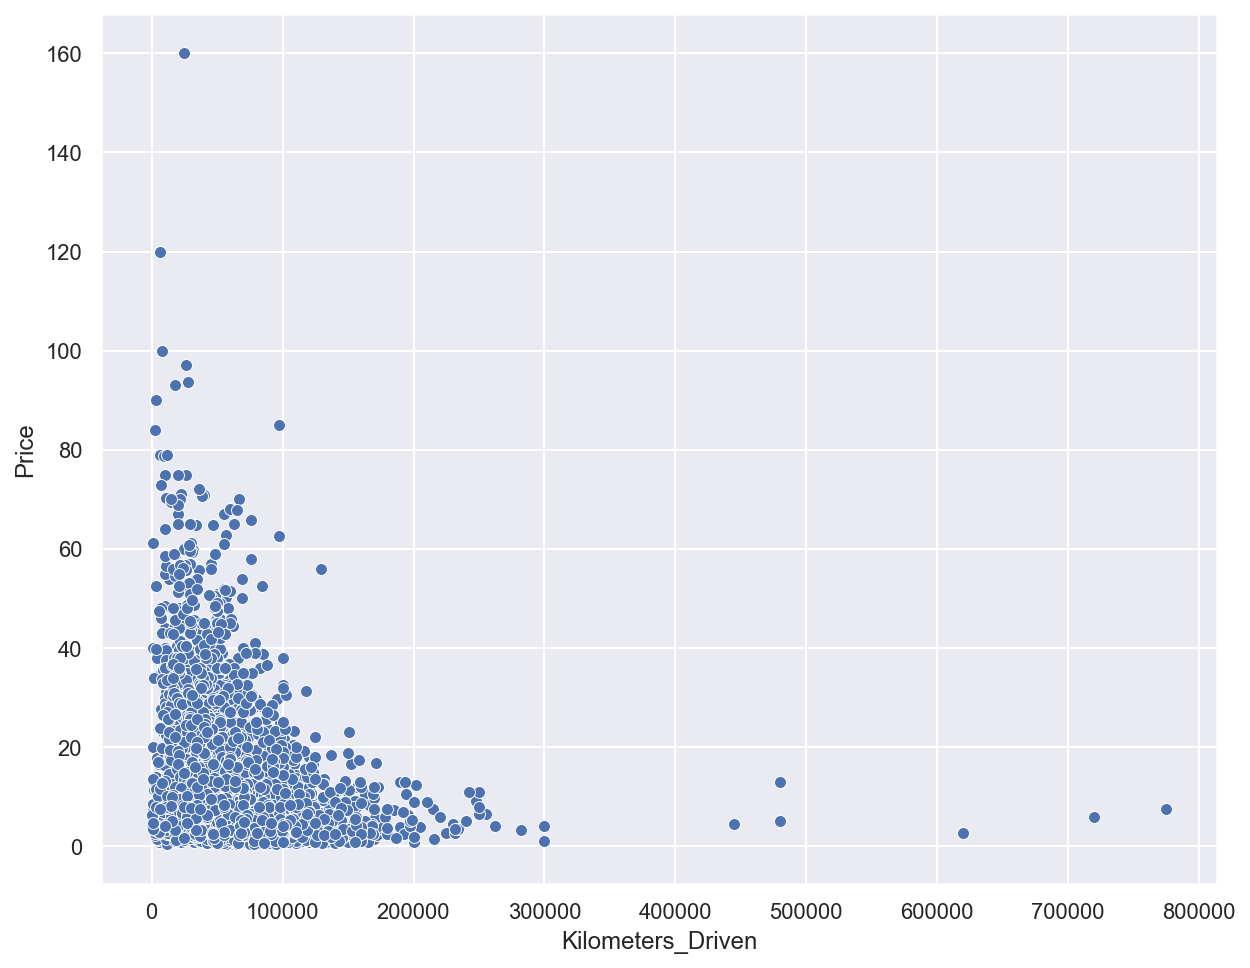

In [19]:
# 삭제 완료~
usedcar_origin = usedcar_origin[usedcar_origin["Kilometers_Driven"]<5000000]
sns.scatterplot(x=usedcar_origin.Kilometers_Driven, y=usedcar_origin.Price);

In [20]:
# (4) Price outlier -> LandRover차로, 구글링해보니 원래 비싼 차.. -> 유지
usedcar_origin[usedcar_origin["Price"]>=150]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
4079,Land Rover Range Rover 3.0 Diesel LWB Vogue,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,160.0


### Name열 활용 어려워 Brand열 추가하여 대치, 소수 브랜드(N < 10)는 원활한 학습 위해 제거

In [21]:
# Name 맨 앞이 브랜드임을 파악, 해당 규칙으로 Brand열 추가
usedcar_origin["Brand"] = usedcar_origin["Name"].str.split(" ", expand=True)[0].\
str.lower()

In [22]:
print(usedcar_origin["Brand"].value_counts())
ls = usedcar_origin["Brand"].value_counts()[usedcar_origin["Brand"].value_counts()<10].keys()
usedcar_origin = usedcar_origin[~(usedcar_origin["Brand"].isin(ls))]
usedcar_origin.drop(columns=["Name"], inplace=True)

maruti           1196
hyundai          1073
honda             601
toyota            407
volkswagen        314
mercedes-benz     306
ford              298
mahindra          269
bmw               261
audi              235
tata              186
skoda             171
renault           145
chevrolet         121
nissan             91
land               51
jaguar             40
mitsubishi         27
mini               26
fiat               24
volvo              21
porsche            18
jeep               15
datsun             13
force               3
isuzu               3
bentley             1
ambassador          1
lamborghini         1
Name: Brand, dtype: int64


In [23]:
# 6019행에서 null 제거해서 5918로 101개가 줄었다.
# 형변환도 다했고, 이상값처리도 완료.
# 브랜드 적은 것도 9개 추가 제거해서 결과적으로 5,909행
print(usedcar_origin.shape)
usedcar_origin.info(), usedcar_origin.describe()

(5909, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5909 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5909 non-null   object 
 1   Year               5909 non-null   int64  
 2   Kilometers_Driven  5909 non-null   int64  
 3   Fuel_Type          5909 non-null   object 
 4   Transmission       5909 non-null   object 
 5   Owner_Type         5909 non-null   object 
 6   Mileage            5909 non-null   float64
 7   Engine             5909 non-null   float64
 8   Power              5909 non-null   float64
 9   Seats              5909 non-null   float64
 10  Price              5909 non-null   float64
 11  Brand              5909 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 600.1+ KB


(None,
               Year  Kilometers_Driven      Mileage       Engine        Power  \
 count  5909.000000        5909.000000  5909.000000  5909.000000  5909.000000   
 mean   2013.424945       57469.794551    18.359890  1617.892198   112.747009   
 std       3.204547       37783.608480     4.177308   593.513980    53.058803   
 min    1998.000000         171.000000     7.500000   624.000000    34.200000   
 25%    2012.000000       33858.000000    15.300000  1198.000000    75.000000   
 50%    2014.000000       53000.000000    18.200000  1493.000000    93.700000   
 75%    2016.000000       72717.000000    21.100000  1968.000000   138.100000   
 max    2019.000000      775000.000000    33.540000  5461.000000   550.000000   
 
              Seats        Price  
 count  5909.000000  5909.000000  
 mean      5.280927     9.441032  
 std       0.803224    11.030069  
 min       2.000000     0.440000  
 25%       5.000000     3.500000  
 50%       5.000000     5.650000  
 75%       5.0000

## 2) 시각화

In [24]:
dummies = ["Brand", "Location", "Fuel_Type", "Transmission", "Owner_Type", "Year"]
name = ["brand", "location", "fuel type", "transmission", "owner type"]

In [25]:
usedcar_origin["Brand"] = usedcar_origin["Brand"].str.replace("mercedes-benz", "benz")

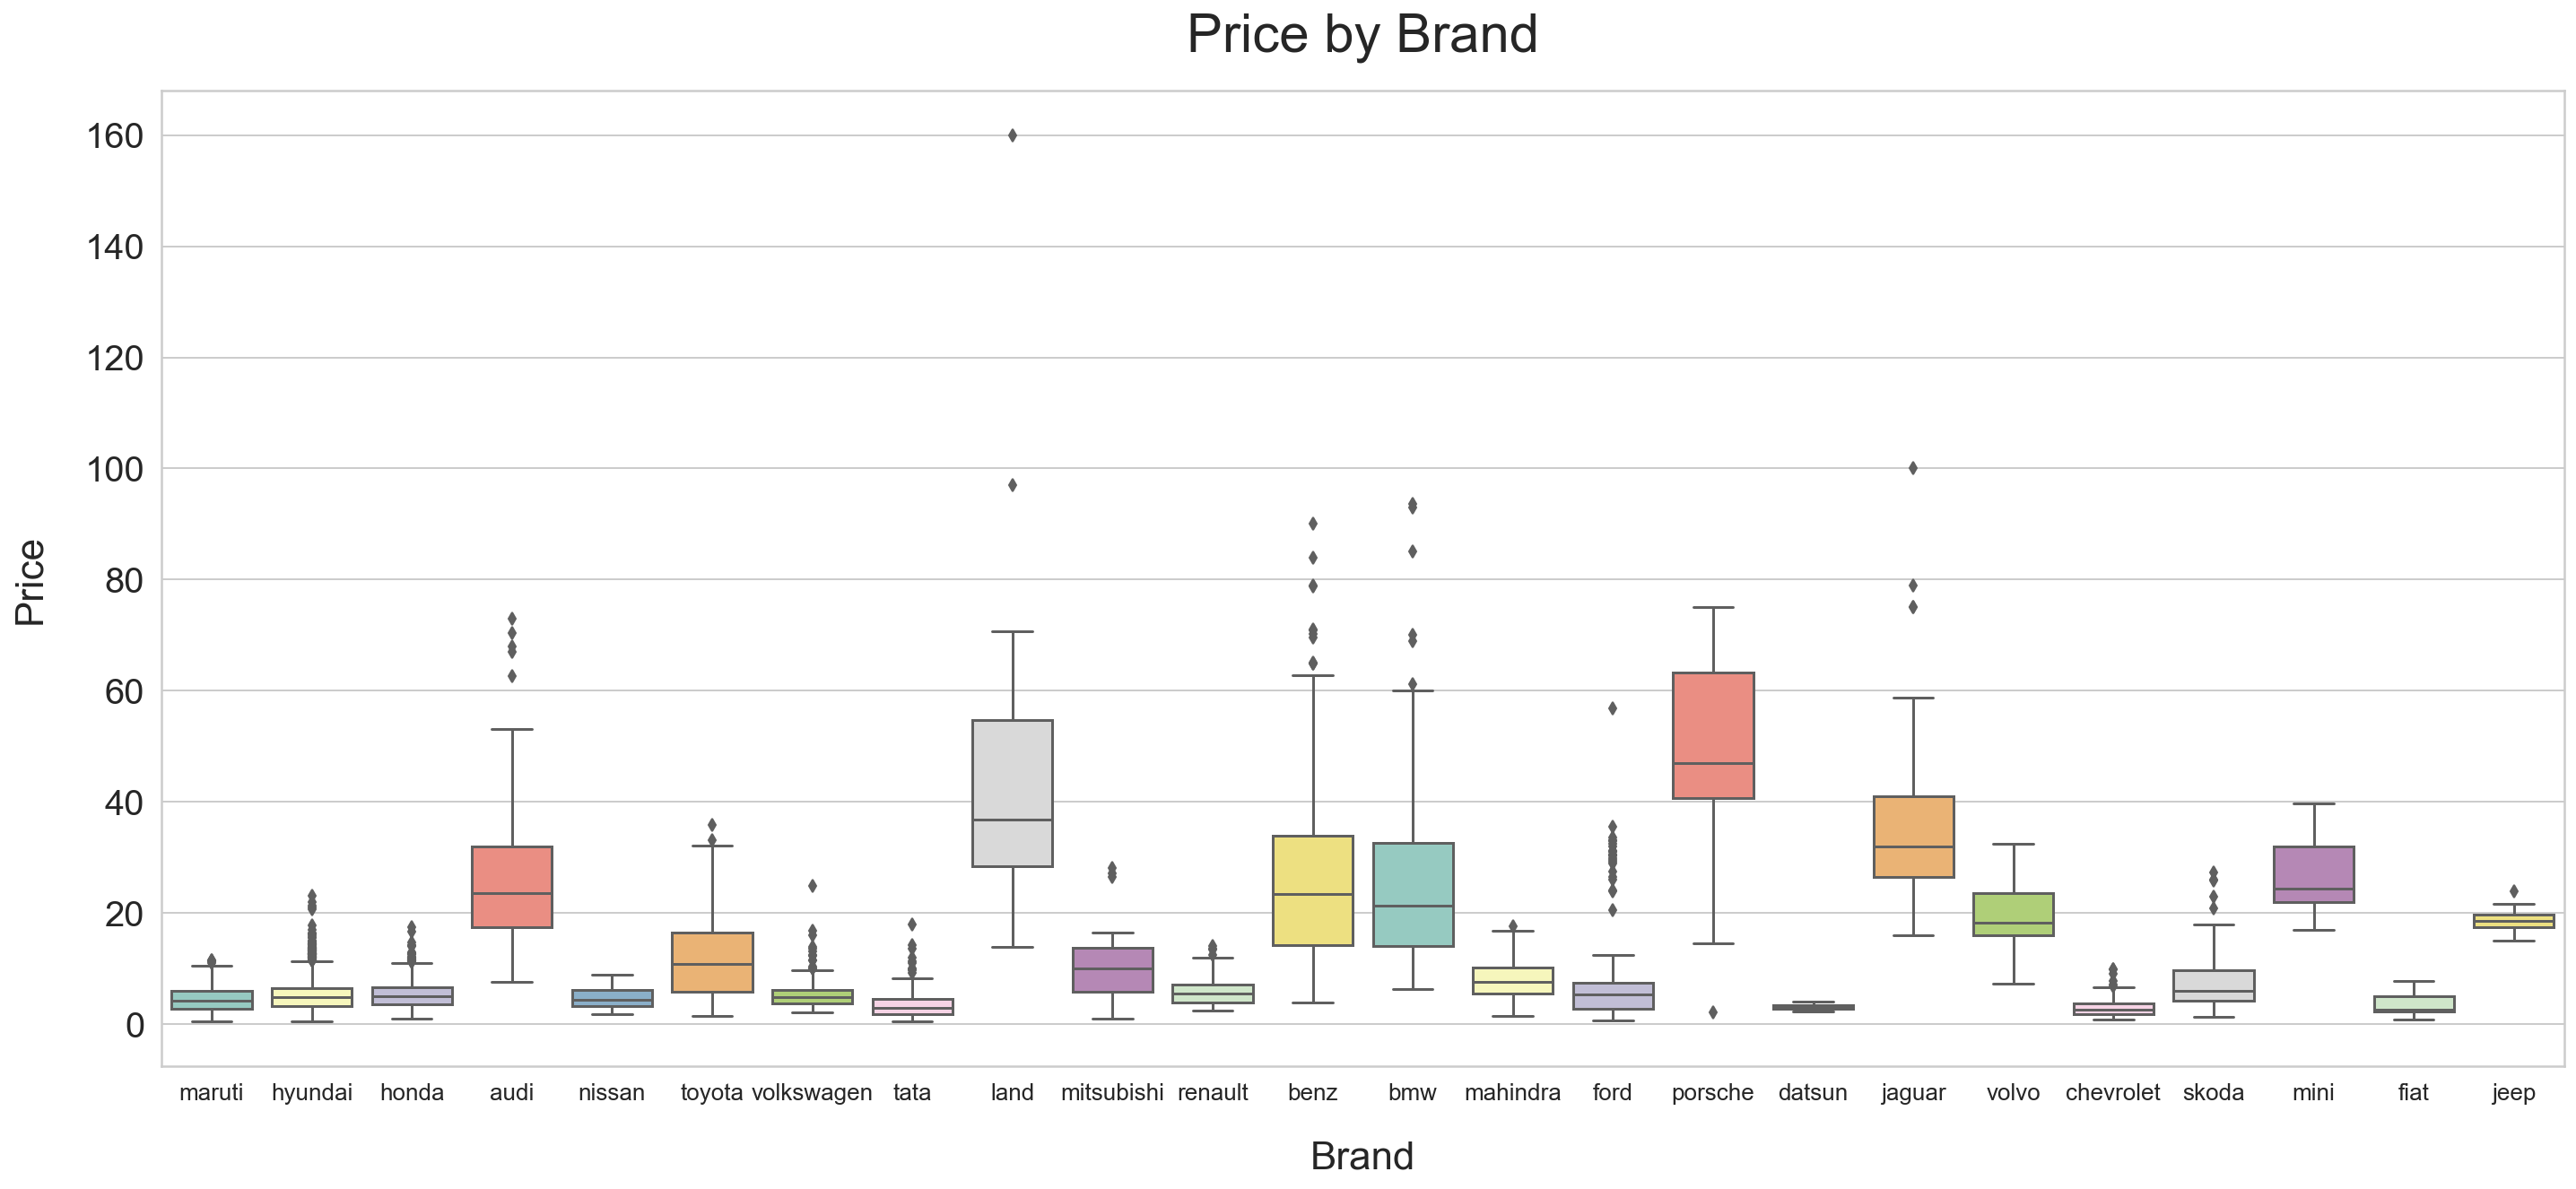

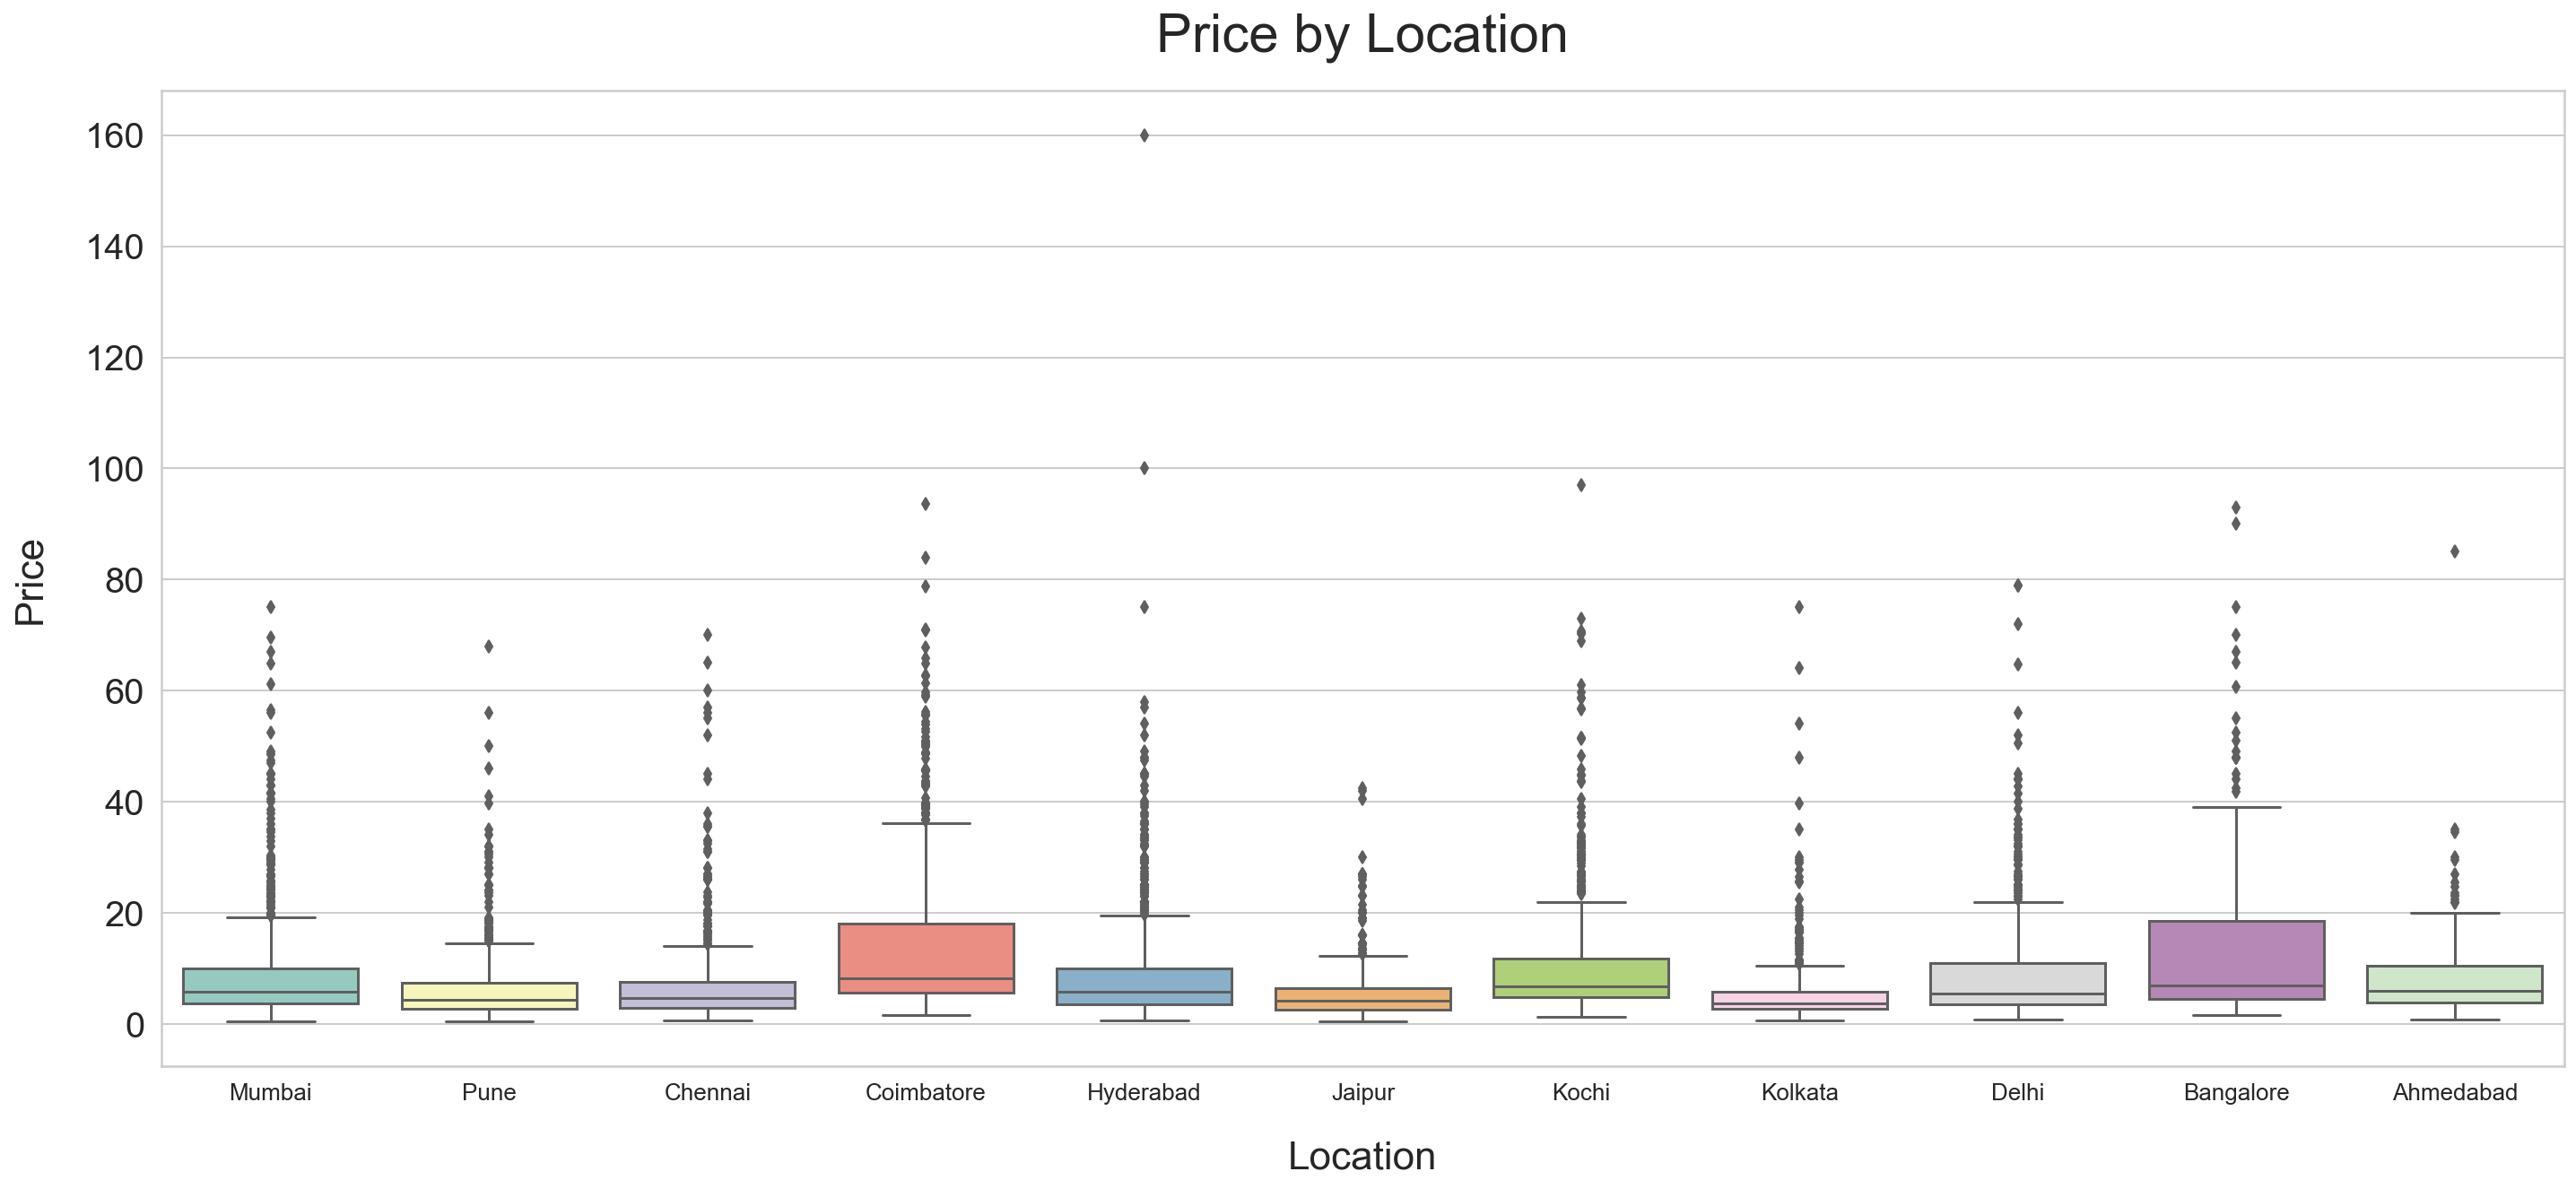

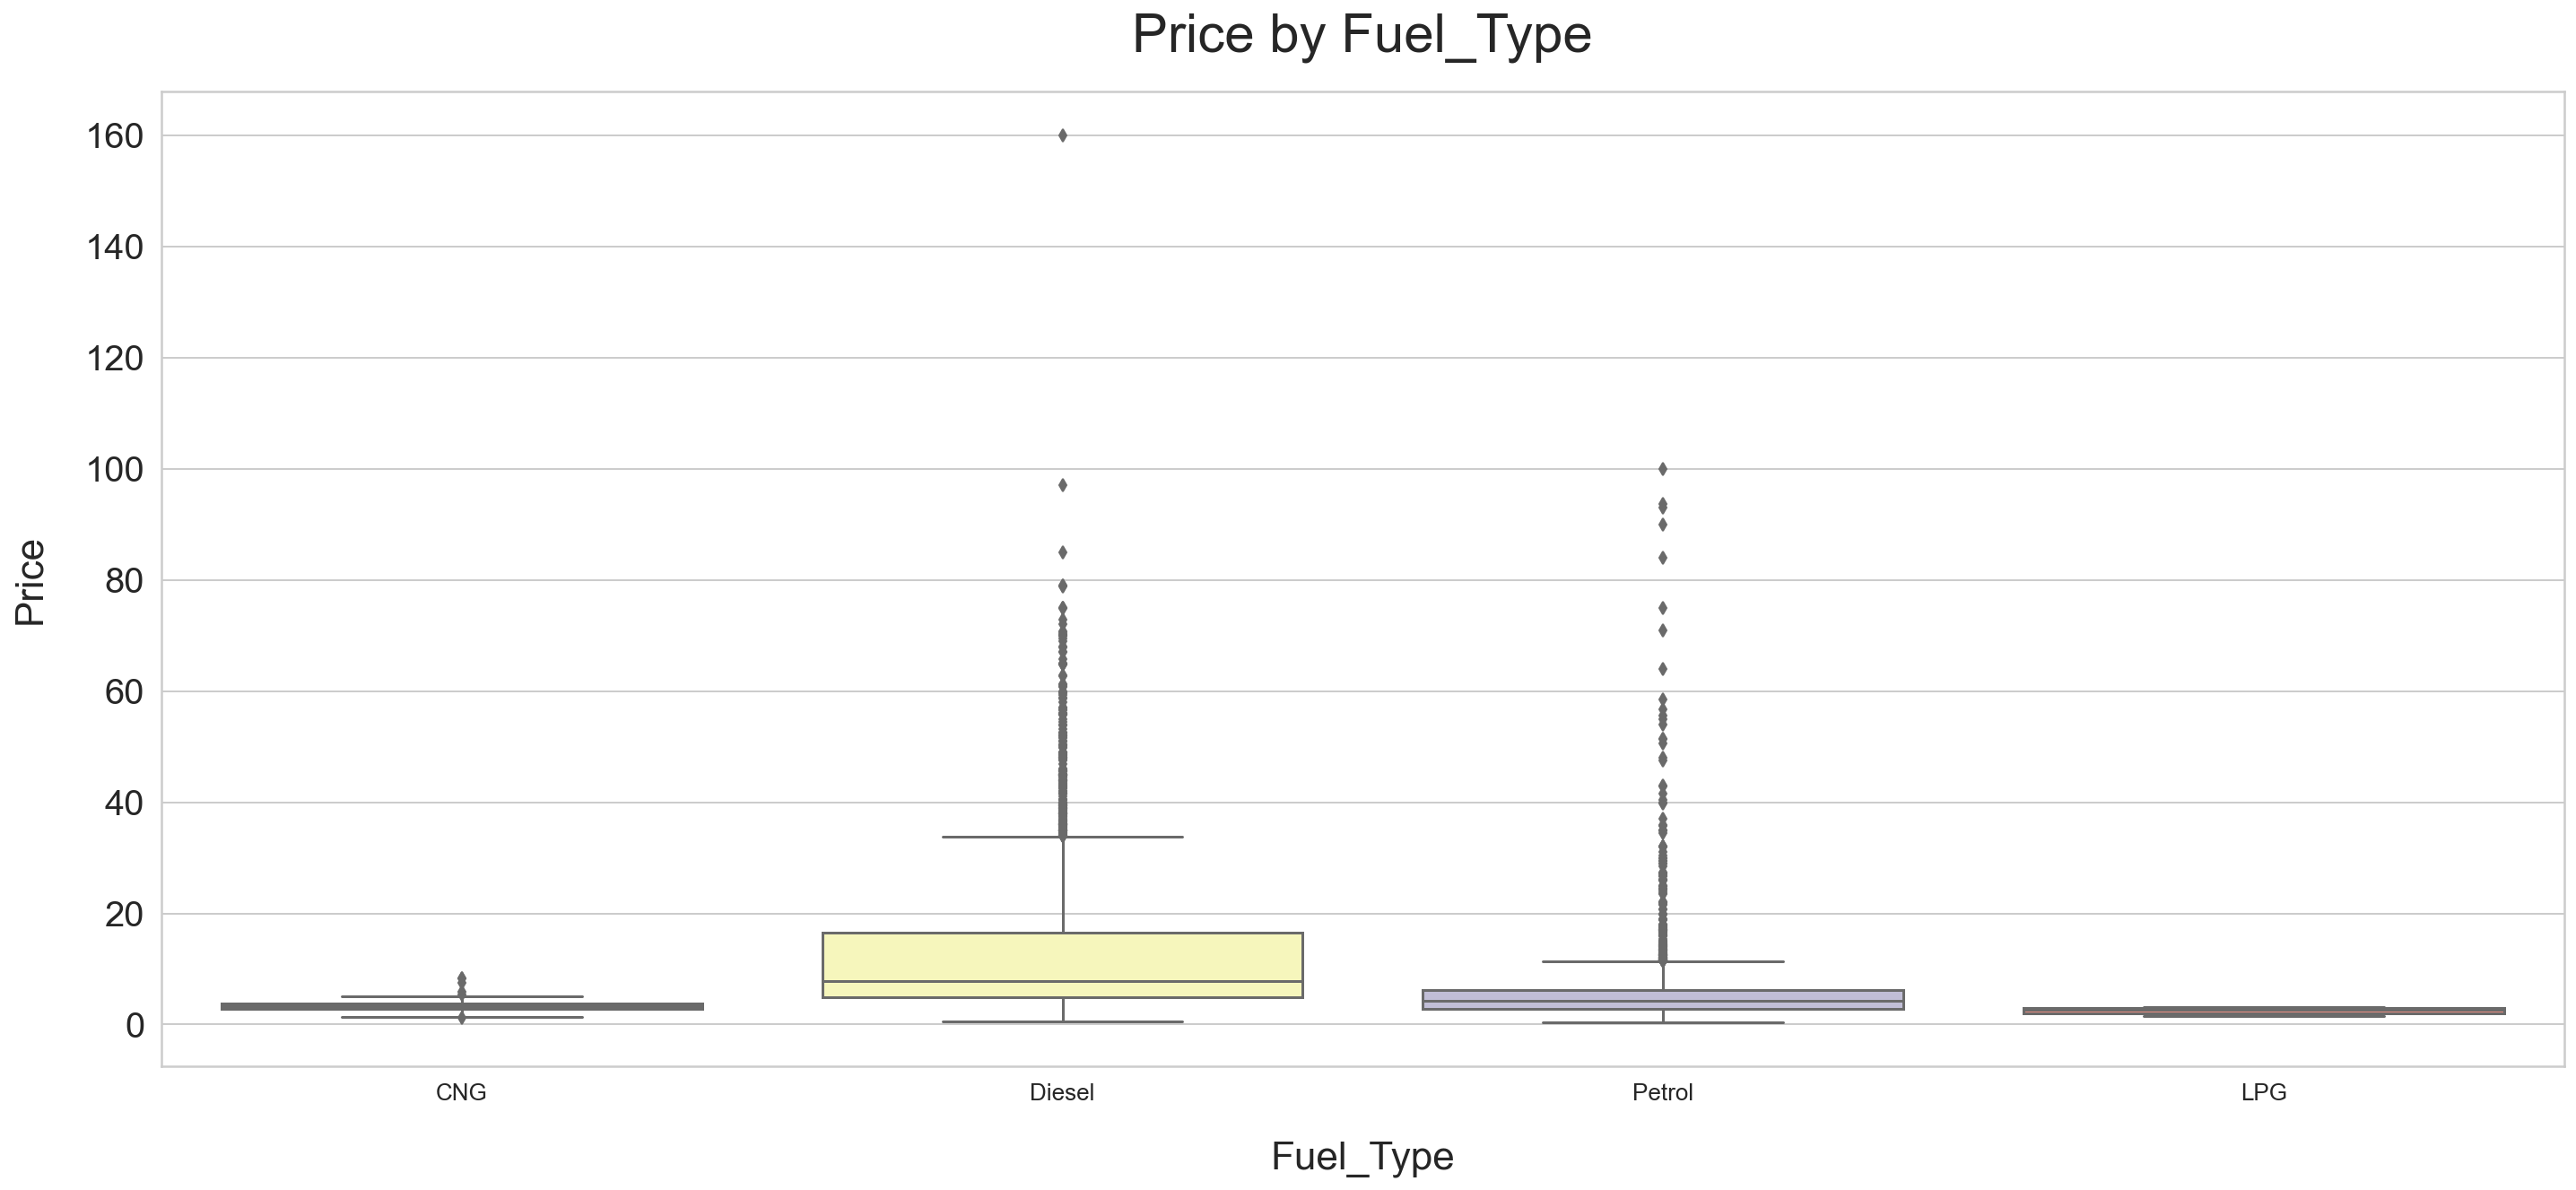

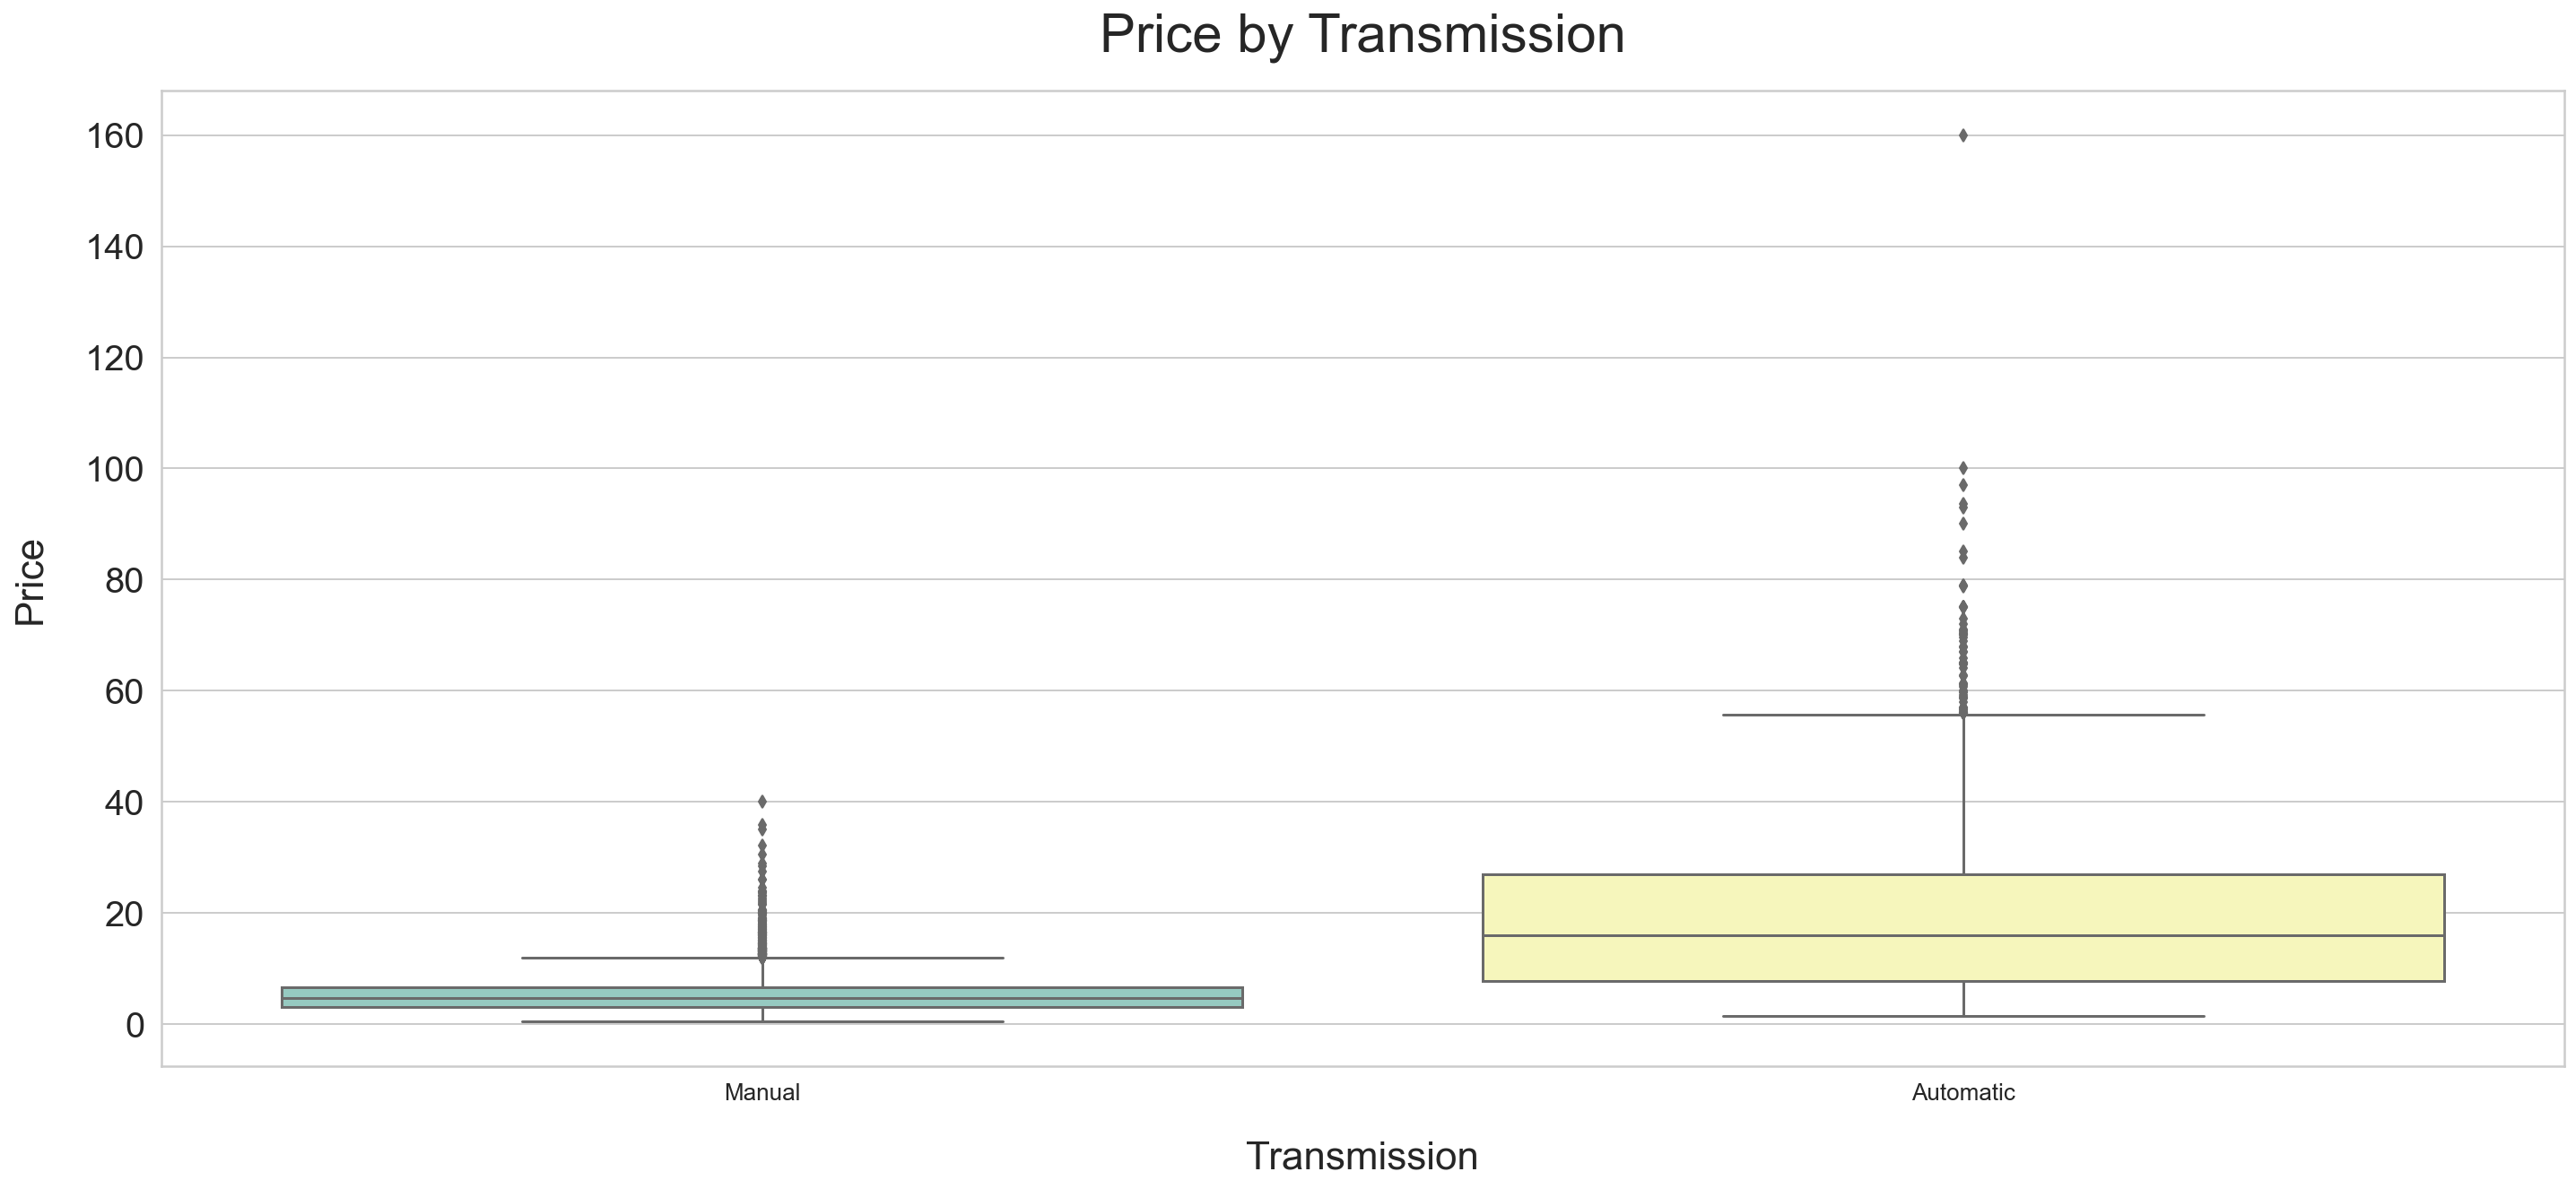

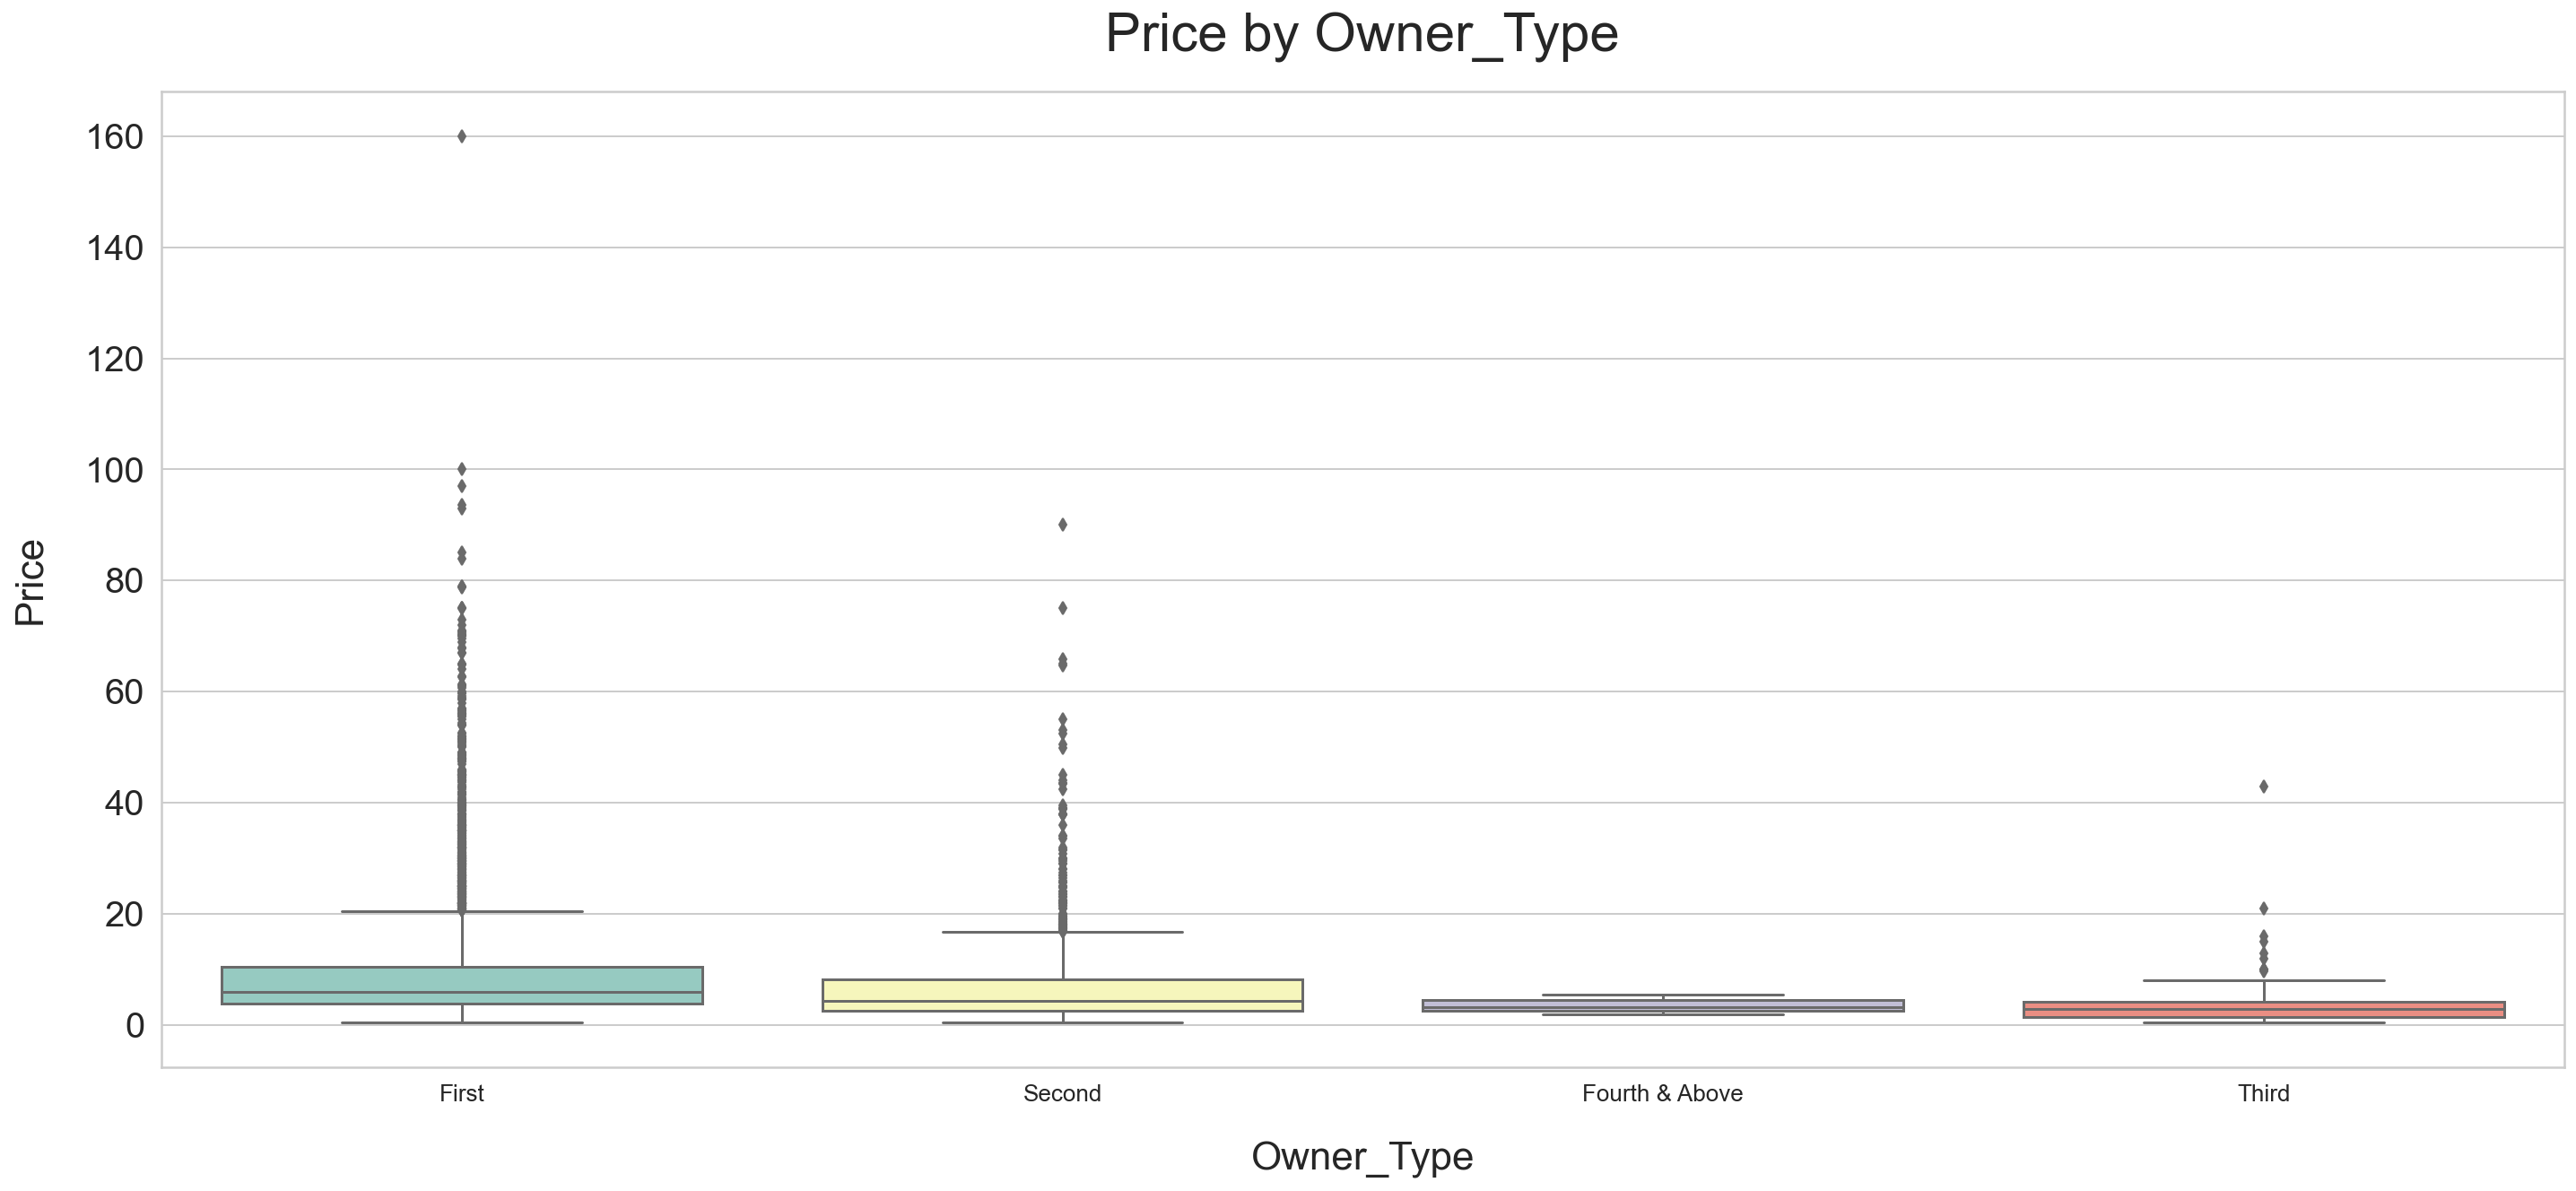

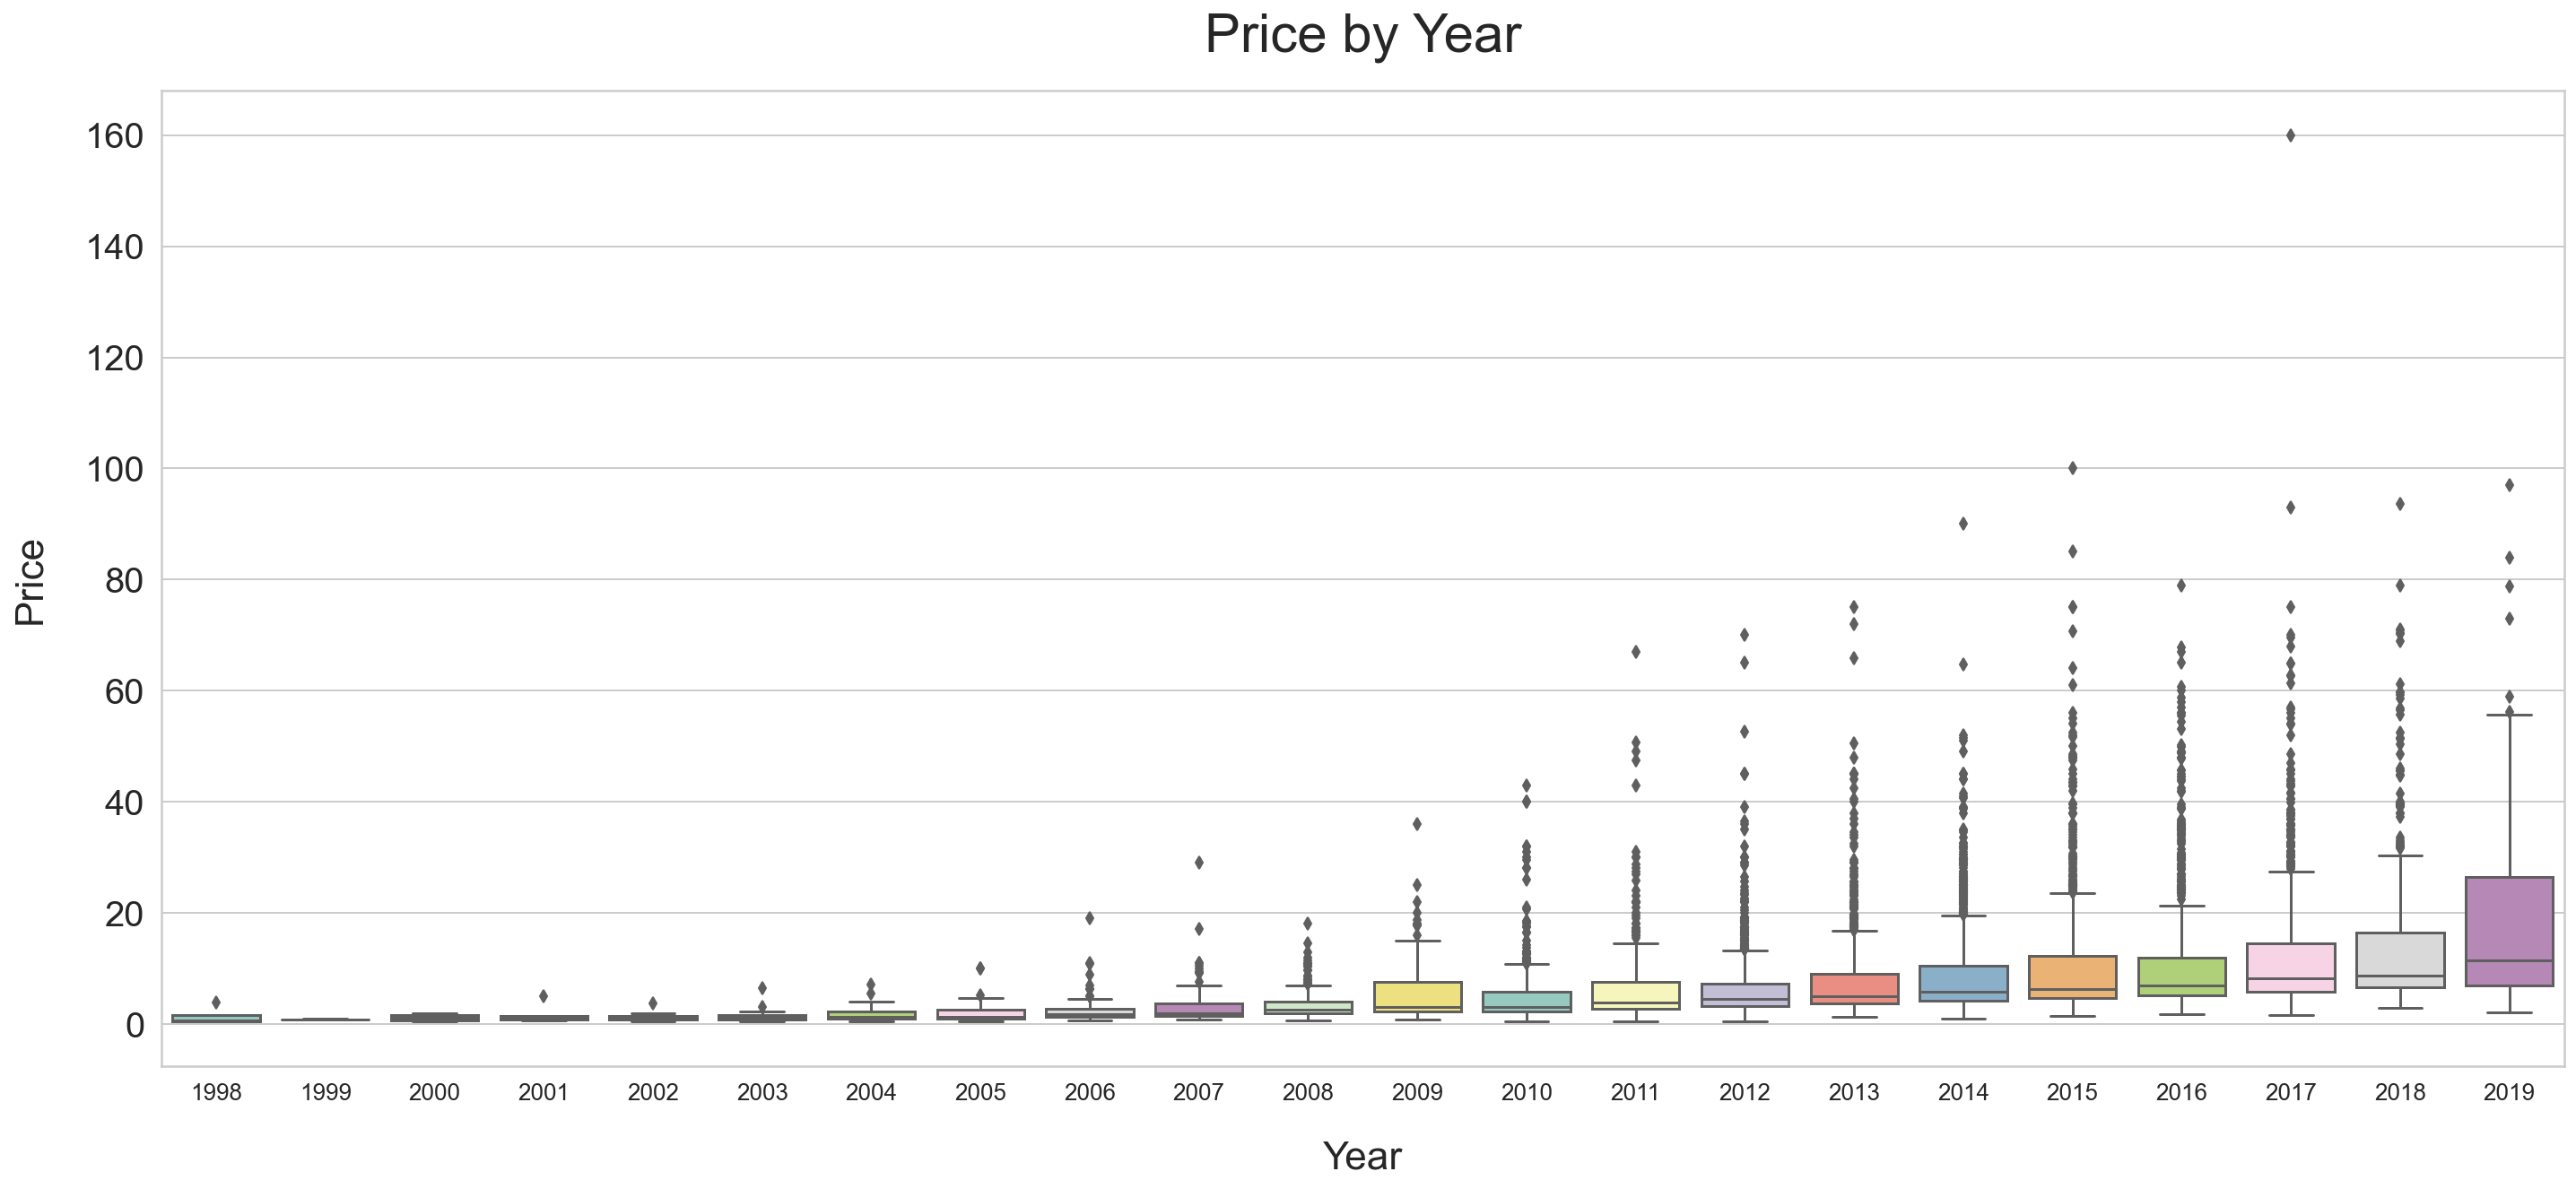

In [26]:
# 범주형 데이터와 price 간의 boxplot을 살펴보면..
for dum in dummies:
    plt.figure(figsize=(24,10))
    sns.set_theme(style="whitegrid")
    sns.boxplot(x=dum, y="Price", 
                data=usedcar_origin, palette="Set3")
    
    plt.title("Price by "+ dum, fontsize=30, y=1.03)
    
    plt.xticks(fontsize=13)
    plt.xlabel(dum, fontsize=22, labelpad=20)
    
    plt.yticks(fontsize=20)
    plt.ylabel("Price", fontsize=22, labelpad=20)
    
    plt.show()

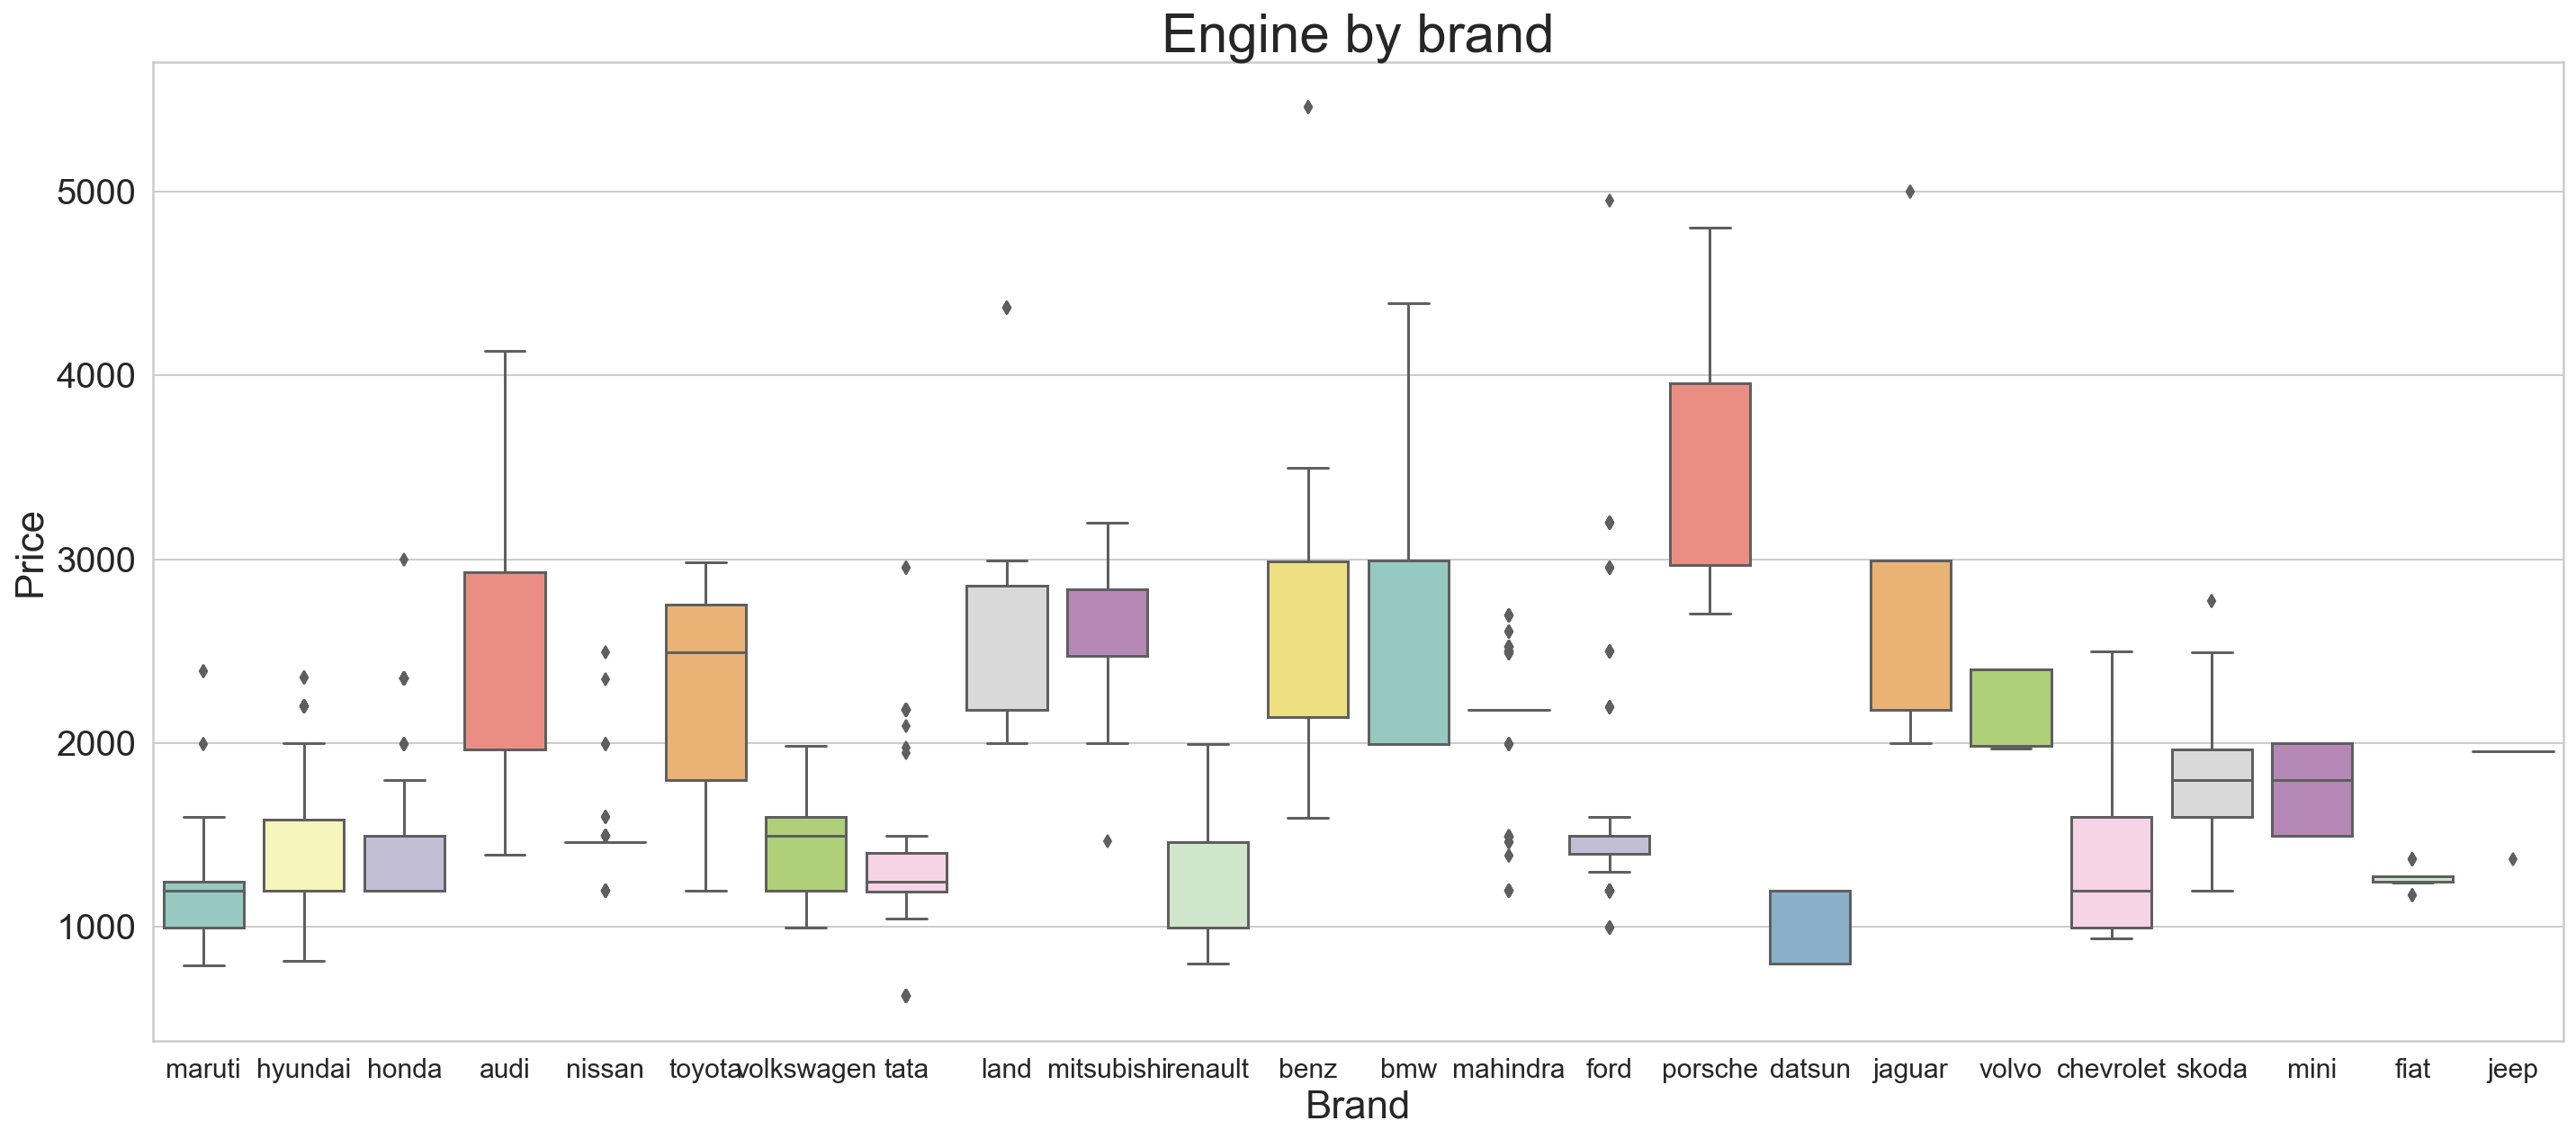

In [27]:
# 브랜드별 엔진 성능을 보면..
plt.figure(figsize=(24,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x="Brand", y="Engine", 
            data=usedcar_origin, palette="Set3")
plt.title("Engine by brand", fontsize=30)
plt.xticks(fontsize=15)
plt.xlabel("Brand", fontsize=22)
plt.yticks(fontsize=20)
plt.ylabel("Price", fontsize=22)
plt.show()

In [28]:
# 년도를 3등분 해보자~
usedcar_origin_for_scatter_plot = usedcar_origin.copy()
usedcar_origin_for_scatter_plot['Year'] = pd.cut(usedcar_origin_for_scatter_plot['Year'], bins=[1998,2008,2016,2019], 
                         include_lowest=True, labels=['1998~2008','2009~2016','2017~2019'])

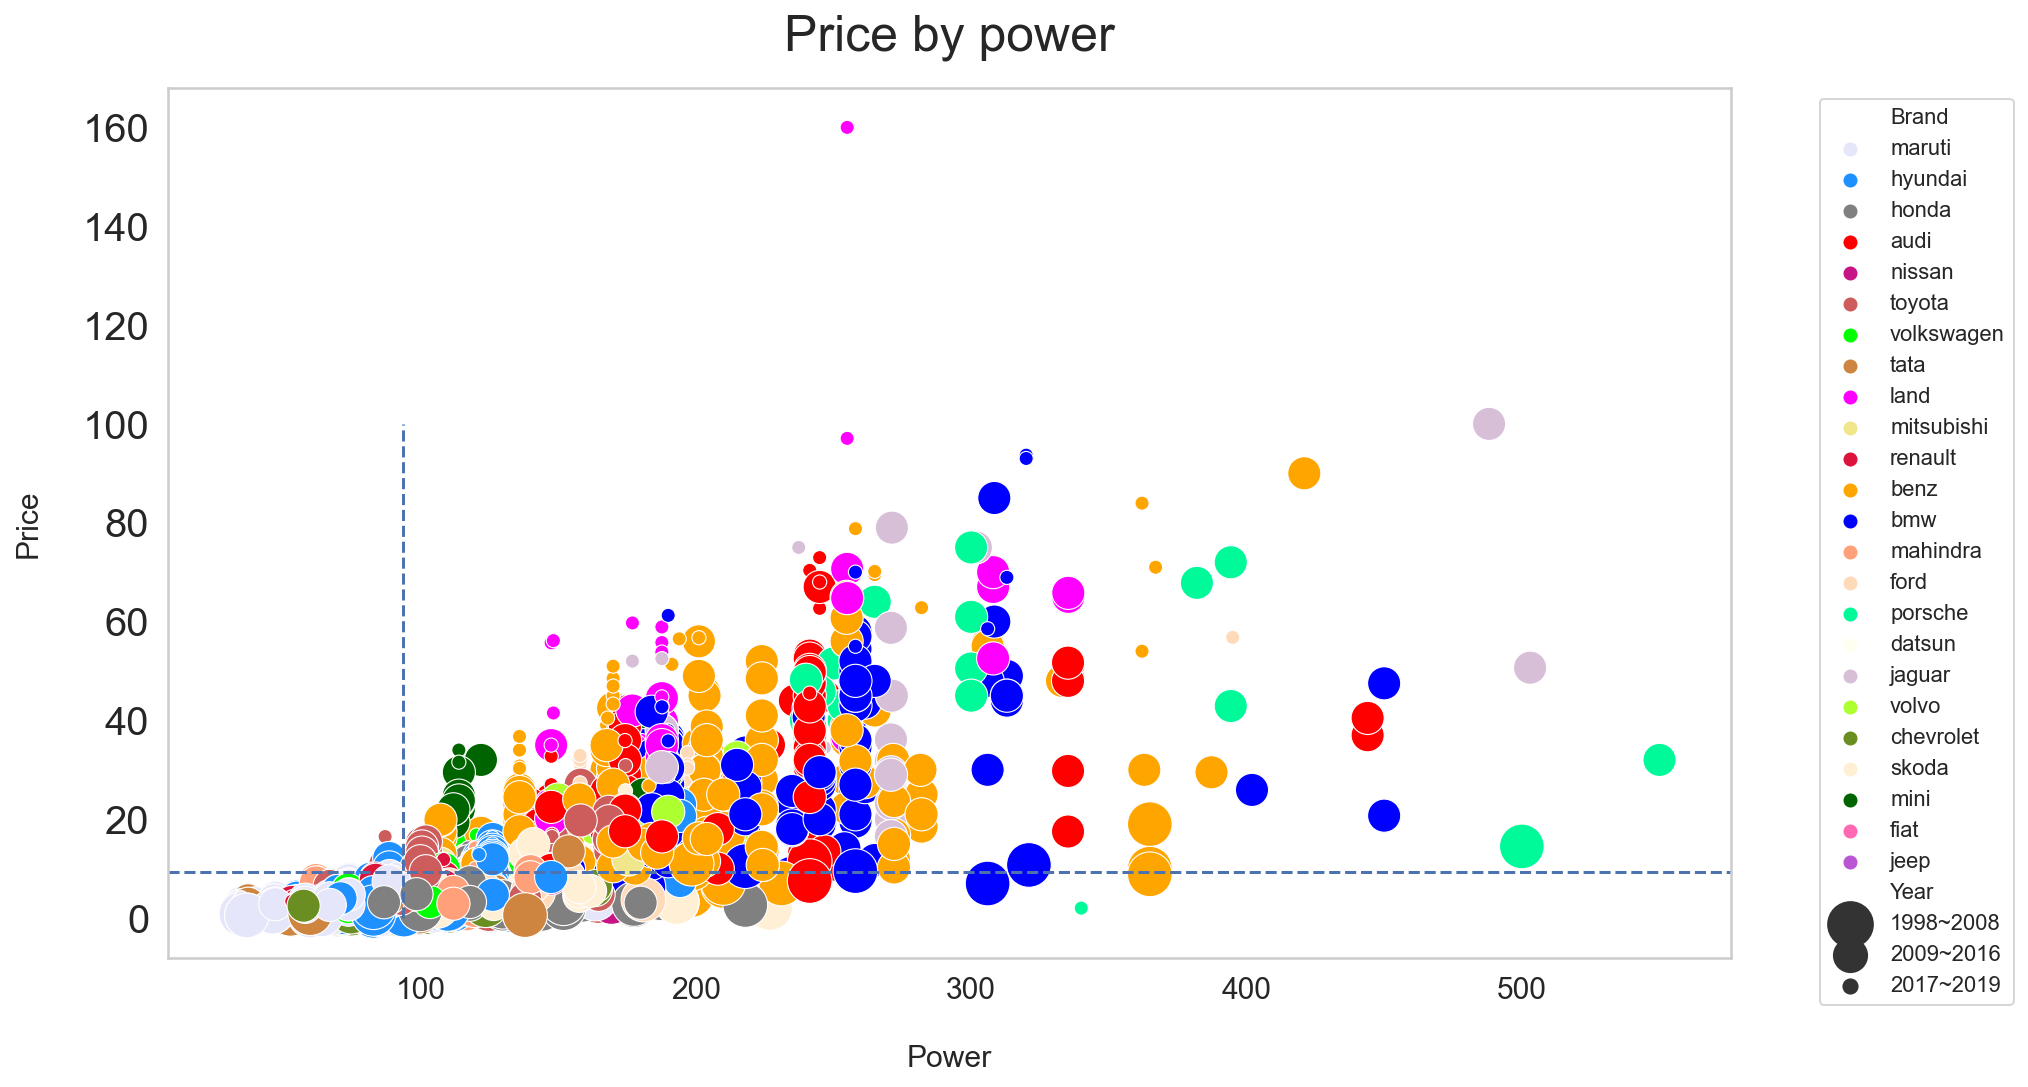

In [29]:
# year 3등분..

plt.figure(figsize=(14,8))

sns.set_theme(style="whitegrid")
sns.scatterplot(x="Power", y="Price", size="Year", 
                sizes=(50,500), data=usedcar_origin_for_scatter_plot, hue="Brand", 
                palette=dict(bmw="blue", benz="orange", land="fuchsia",
                            mahindra="lightsalmon", honda="gray", mini="darkgreen", 
                             maruti="lavender", mitsubishi="khaki", volvo="greenyellow",
                             toyota="indianred", nissan="mediumvioletred", fiat="hotpink",
                             porsche="mediumspringgreen", hyundai="dodgerblue", chevrolet="olivedrab",
                             volkswagen="lime", tata="peru", jeep="mediumorchid", 
                             renault="crimson",datsun="ivory", audi="red", 
                             ford="peachpuff", skoda="papayawhip", jaguar="thistle")
               )
# title
plt.title('Price by power', fontsize=25, y=1.03)

# x ticks & label 
plt.xticks(fontsize=15)
plt.xlabel("Power", fontsize=15, labelpad=20)

# y ticks & label
plt.yticks(fontsize=20)
plt.ylabel("Price", fontsize=15, labelpad=20)

# 그래프안에 점선
plt.axhline(y=9.415548, xmin=0, xmax=550, ls="dashed") # Price 평균값
plt.vlines(x=93.700000, ymin=0, ymax=100, ls="dashed") # Power 중앙값

# legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.show();

In [30]:
# 각 사분면 확인으로 나눠서 다시 그려보자~

In [31]:
# 사분면
raw_1 = usedcar_origin_for_scatter_plot.loc[(usedcar_origin_for_scatter_plot["Price"] > usedcar_origin_for_scatter_plot["Price"].mean()) & (usedcar_origin_for_scatter_plot["Power"] > usedcar_origin_for_scatter_plot["Power"].median()) ] # 제1사분면
raw_2 = usedcar_origin_for_scatter_plot.loc[(usedcar_origin_for_scatter_plot["Price"] > usedcar_origin_for_scatter_plot["Price"].mean()) & (usedcar_origin_for_scatter_plot["Power"] < usedcar_origin_for_scatter_plot["Power"].median()) ] # 제2사분면
raw_3 = usedcar_origin_for_scatter_plot.loc[(usedcar_origin_for_scatter_plot["Price"] < usedcar_origin_for_scatter_plot["Price"].mean()) & (usedcar_origin_for_scatter_plot["Power"] < usedcar_origin_for_scatter_plot["Power"].median()) ] # 제3사분면
raw_4 = usedcar_origin_for_scatter_plot.loc[(usedcar_origin_for_scatter_plot["Price"] < usedcar_origin_for_scatter_plot["Price"].mean()) & (usedcar_origin_for_scatter_plot["Power"] > usedcar_origin_for_scatter_plot["Power"].median()) ] # 제4사분면

In [32]:
raw_all = [raw_1, raw_2, raw_3, raw_4]
raw_name = ["The first quarter", "The second quarter", "The third quarter", "The forth quarter"]

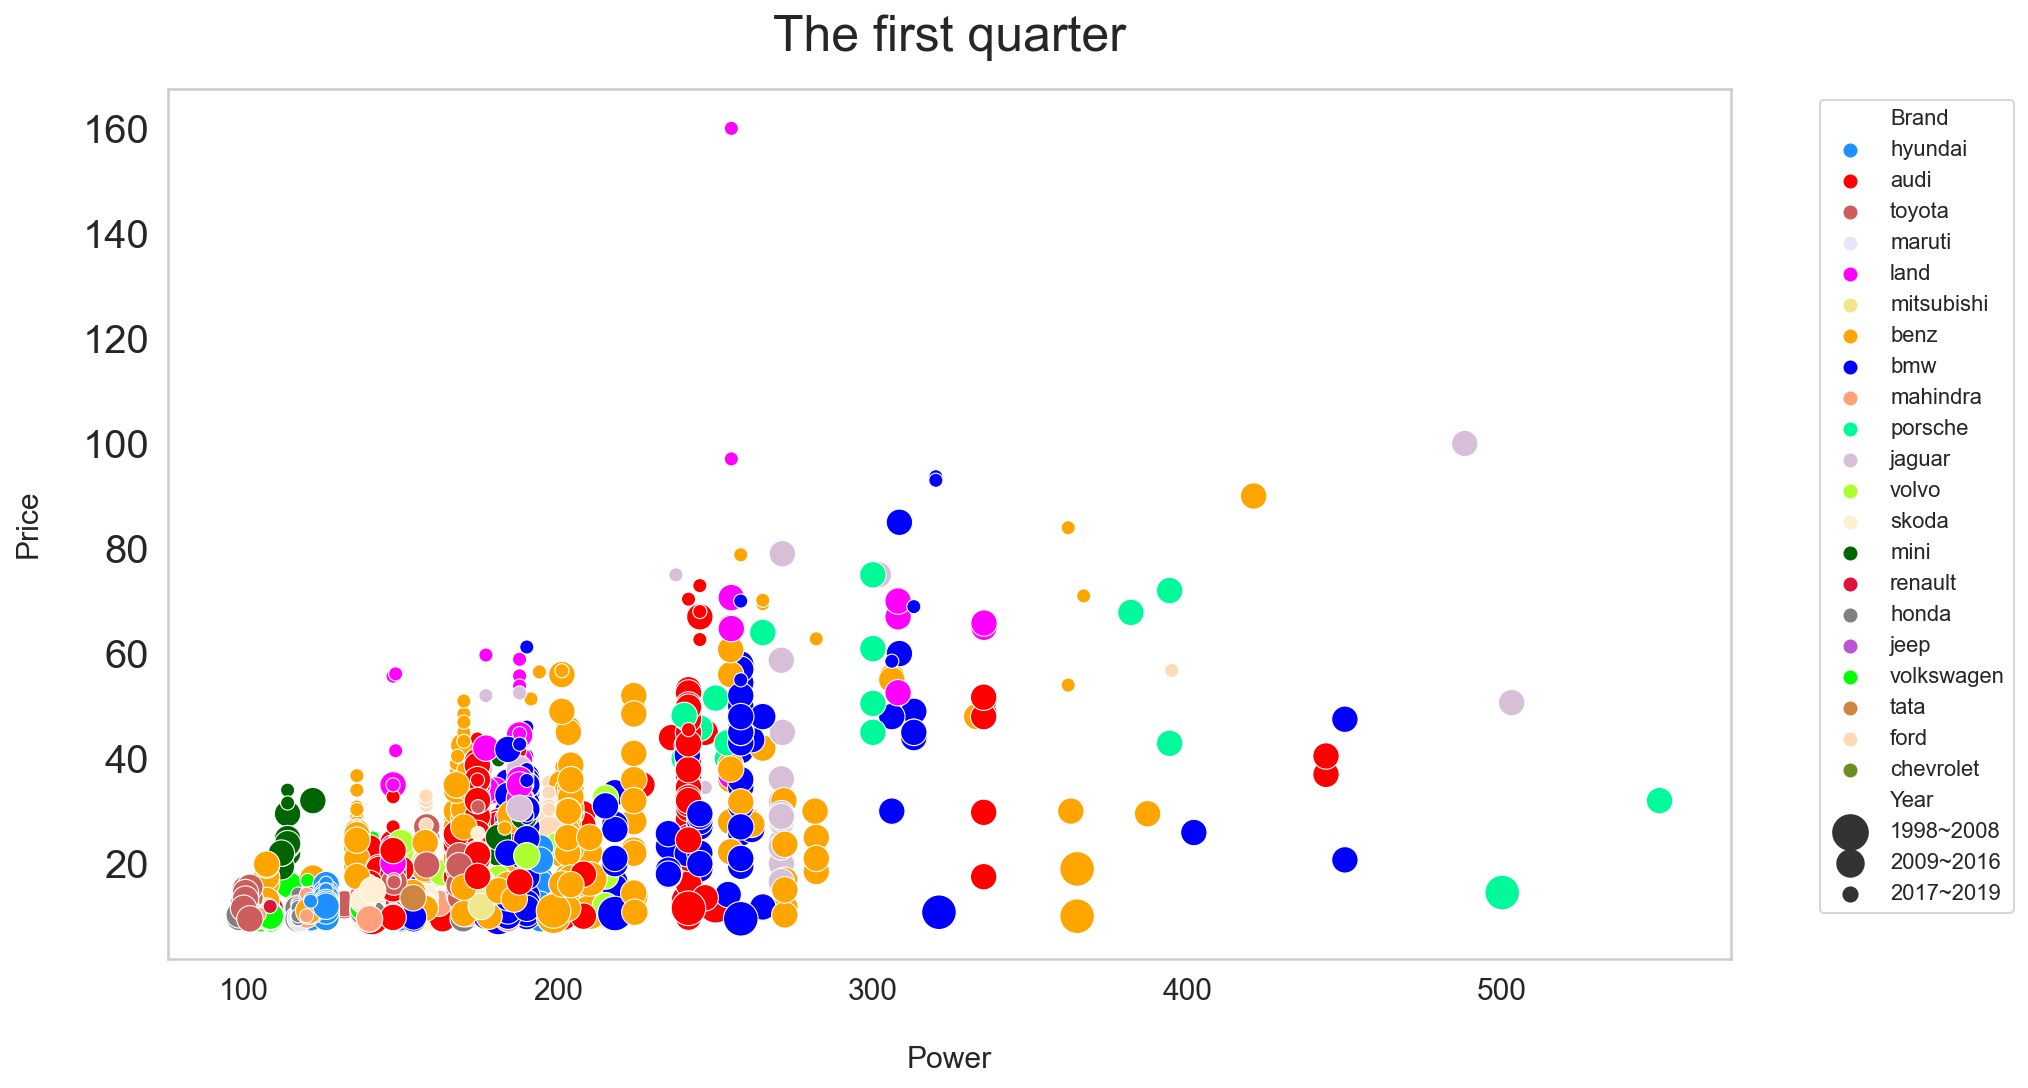

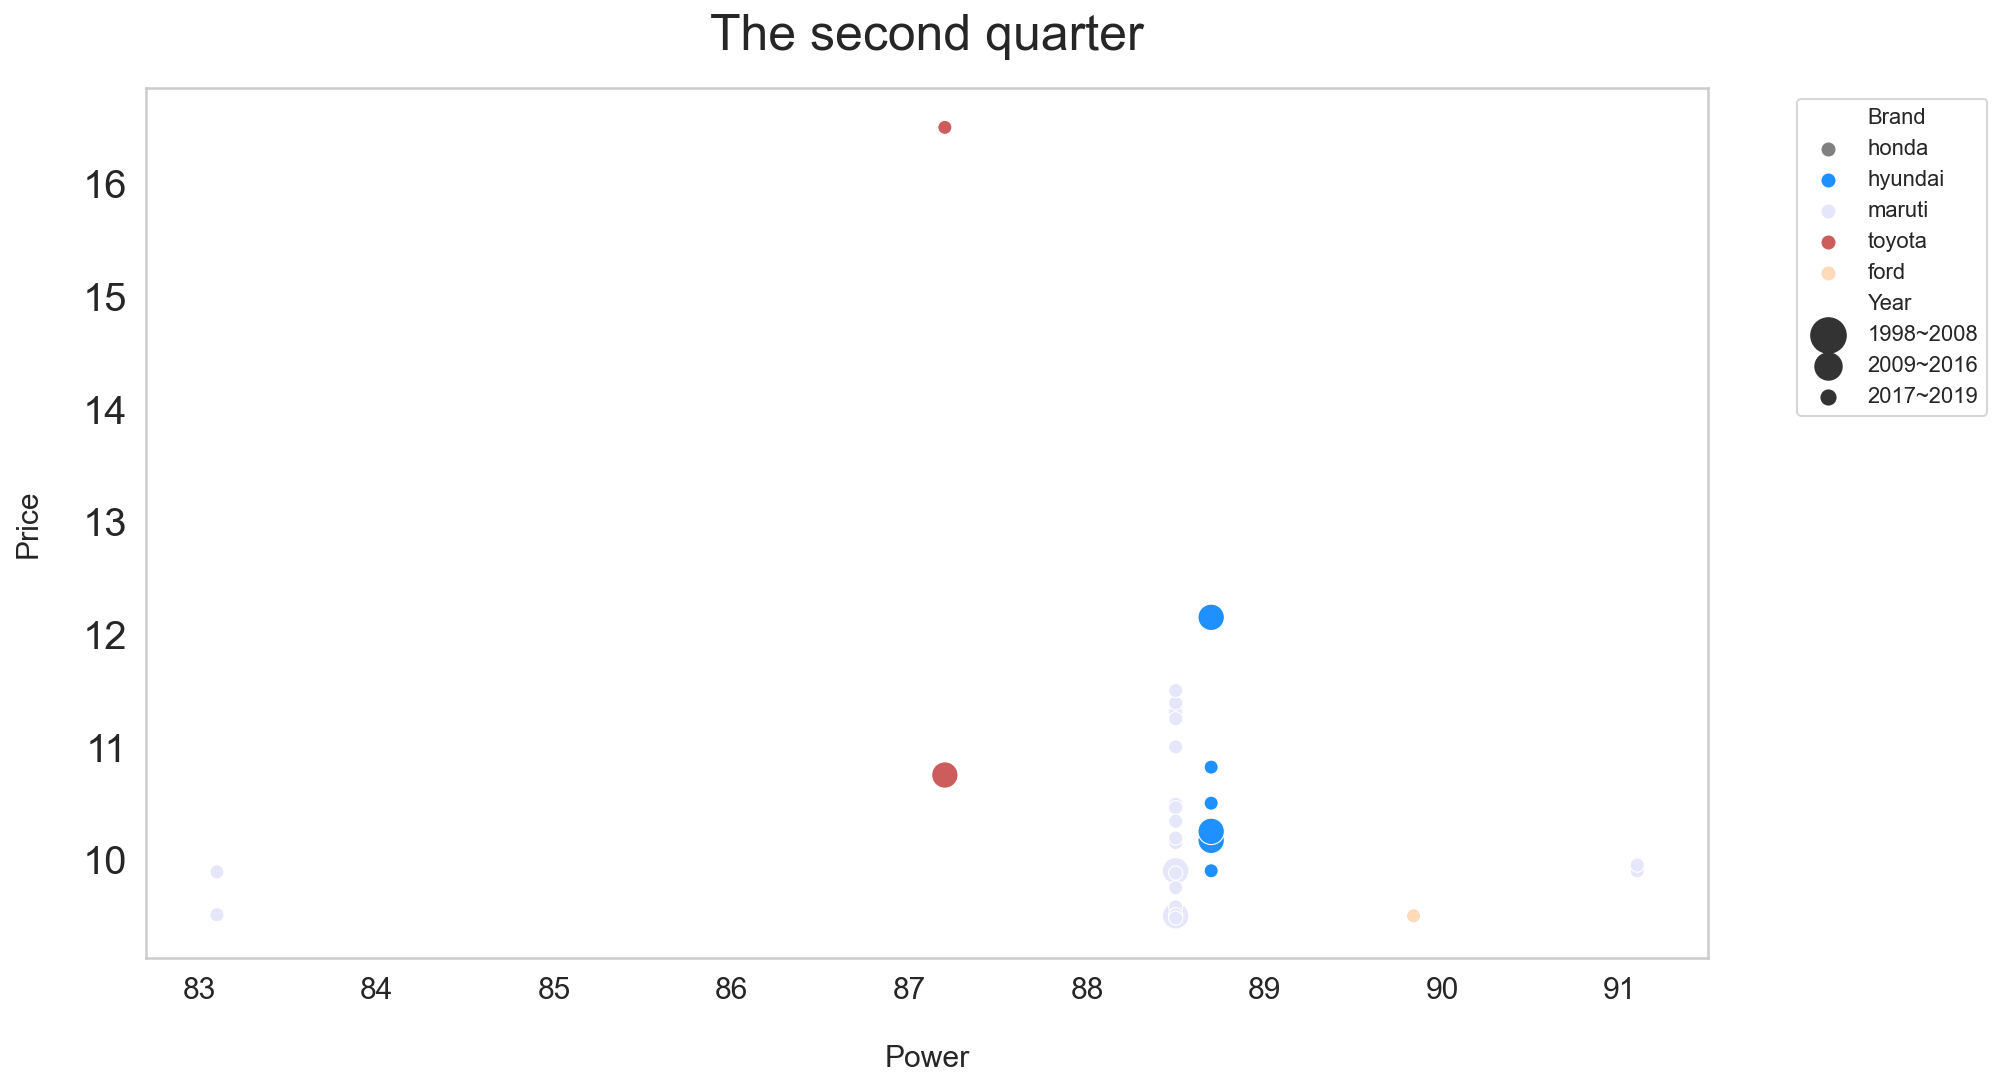

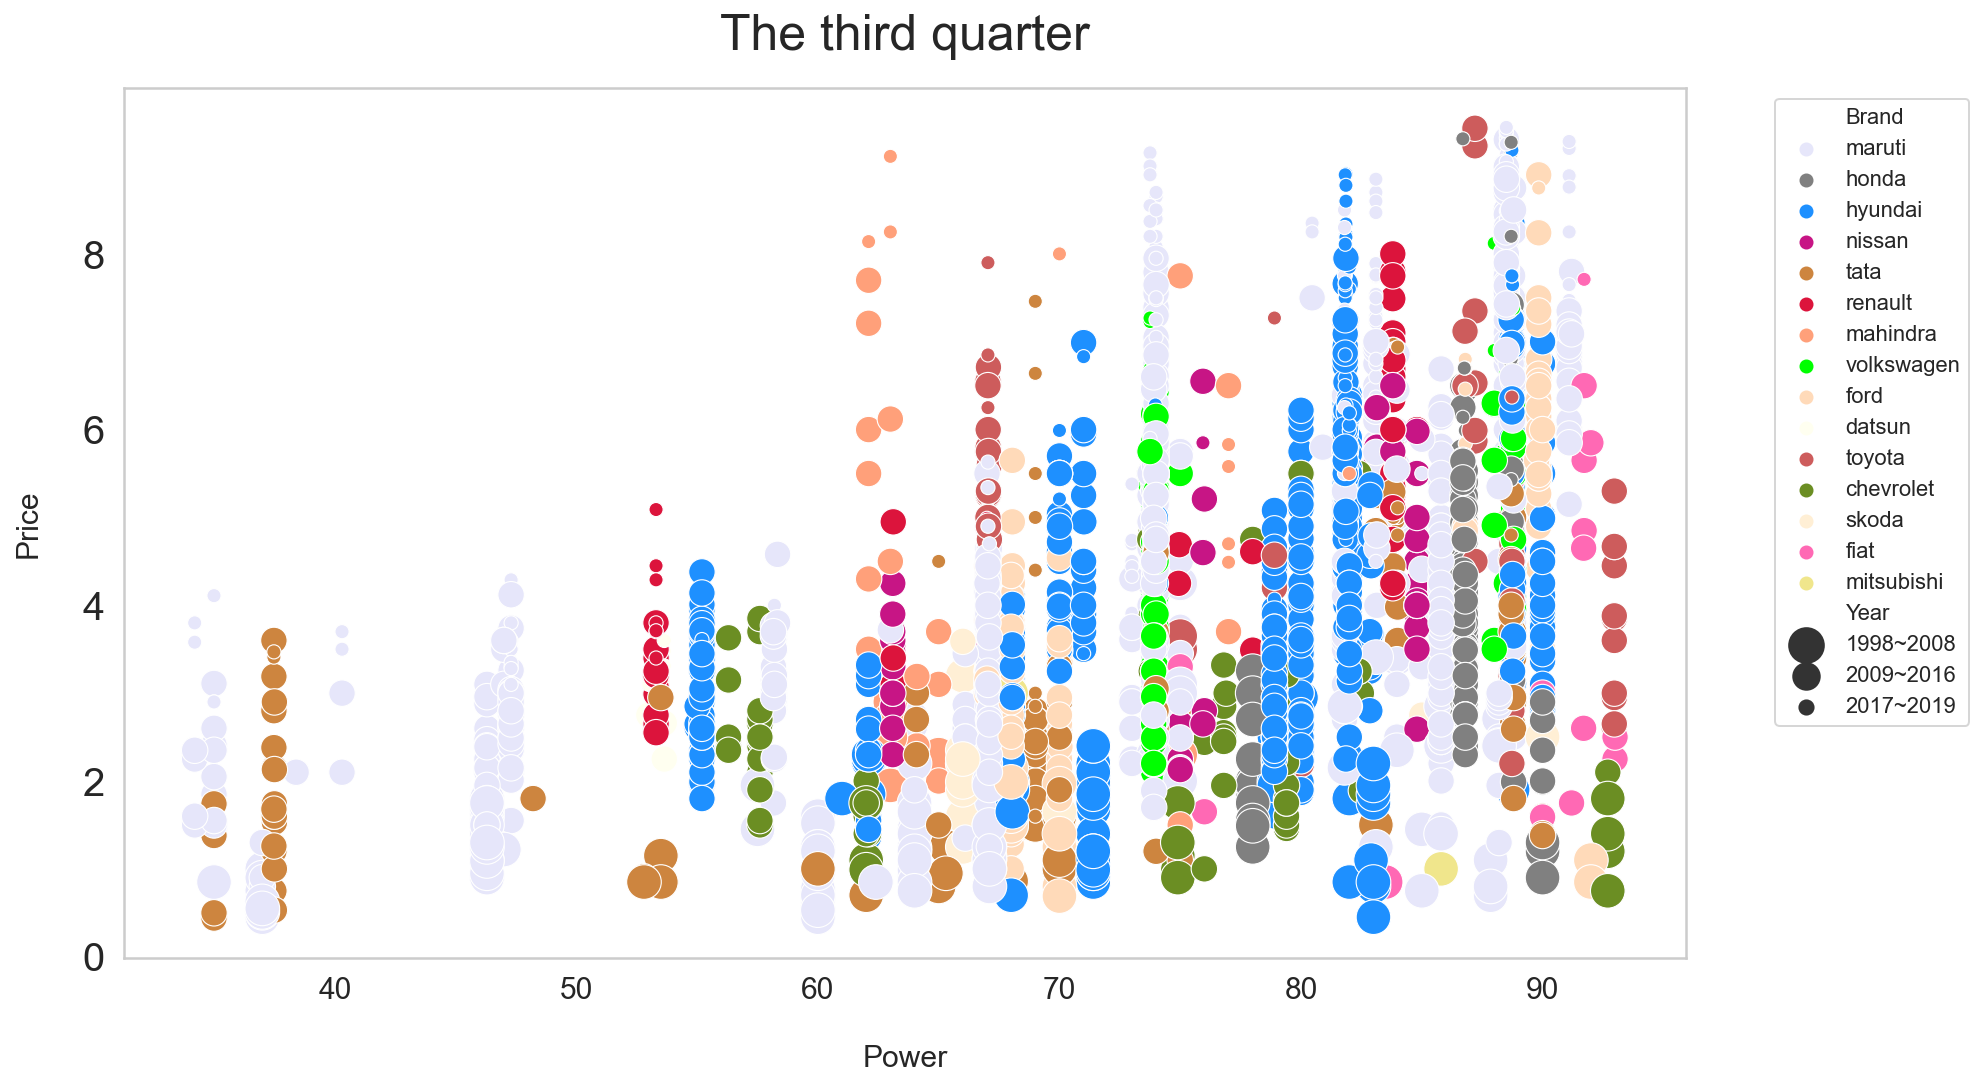

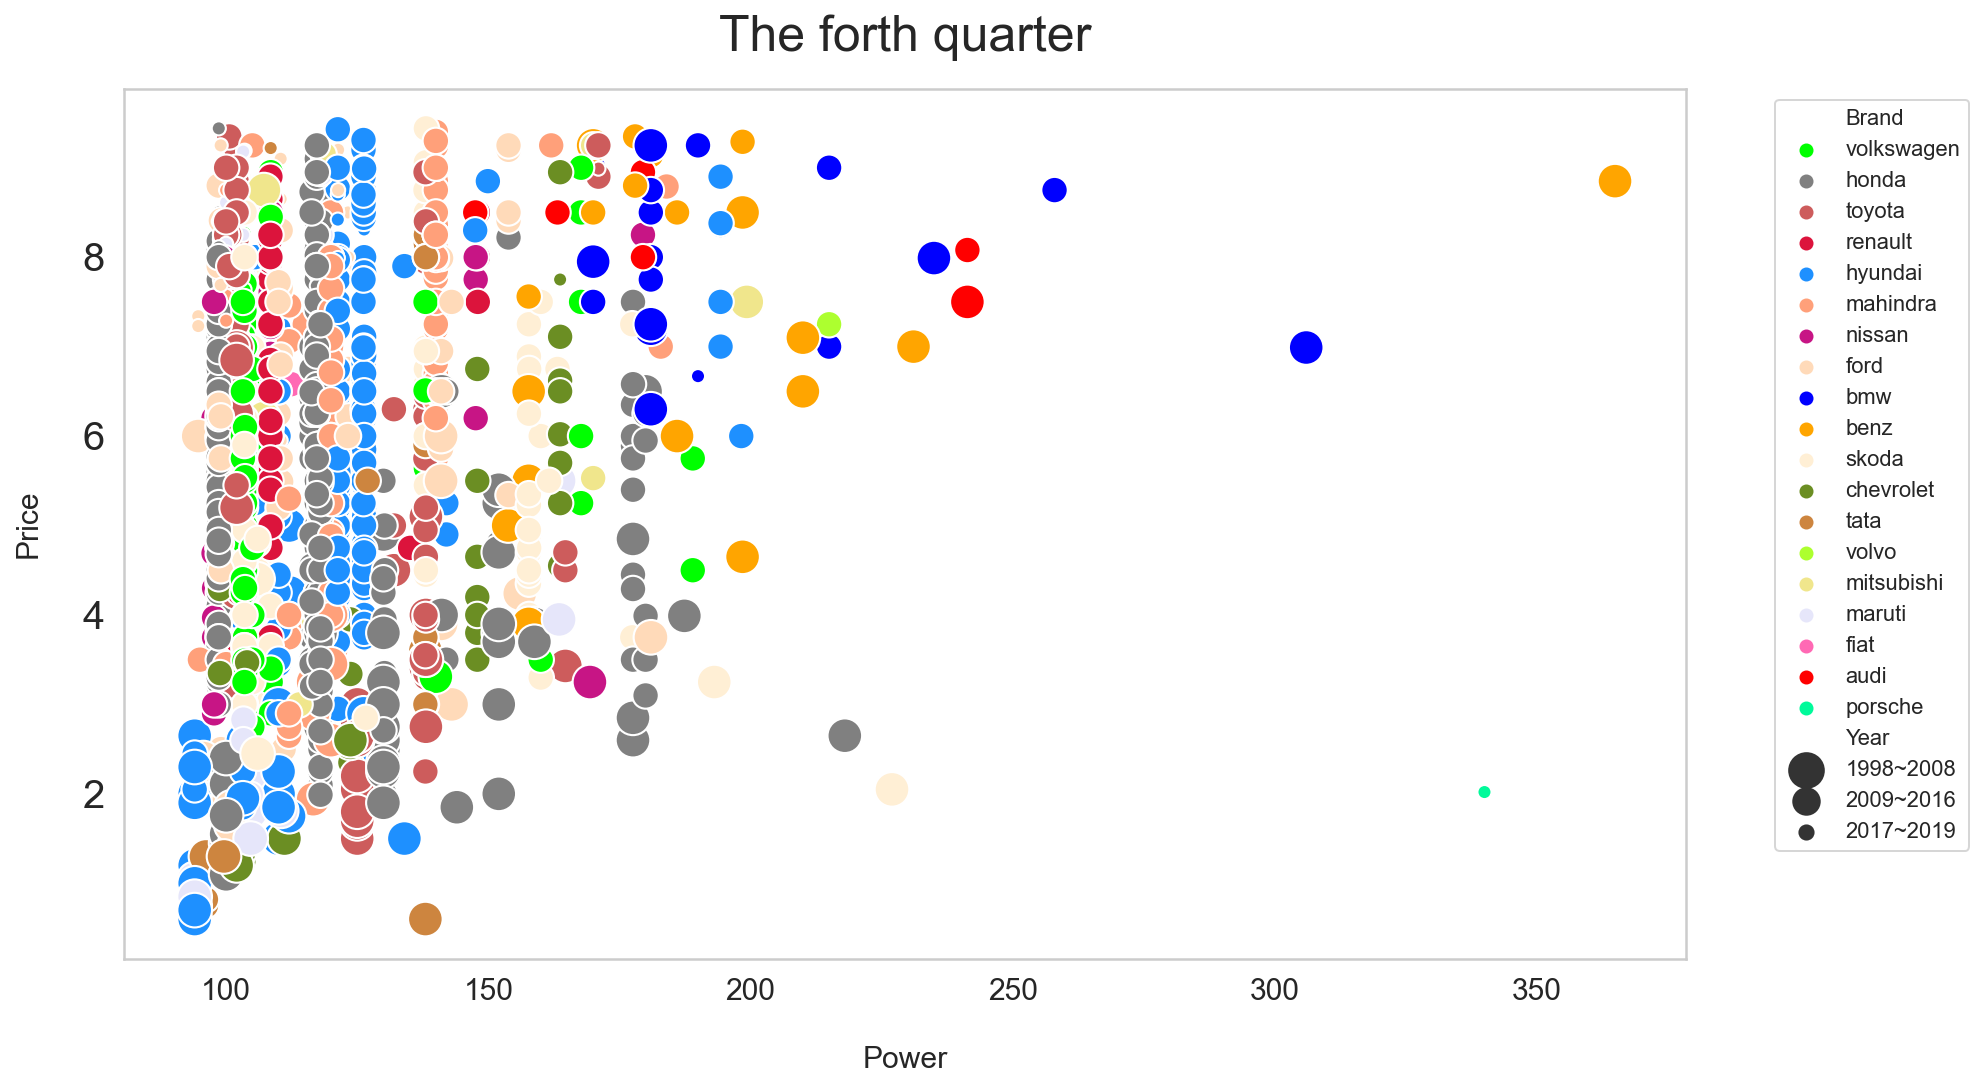

In [33]:
for raw, name in zip(raw_all, raw_name): 
    plt.figure(figsize=(14,8))

    sns.set_theme(style="whitegrid")
    sns.scatterplot(x="Power", y="Price", size="Year", 
                    sizes=(50, 300), data=raw, hue="Brand", 
                    palette=dict(bmw="blue", benz="orange", land="fuchsia",
                                mahindra="lightsalmon", honda="gray", mini="darkgreen", 
                                 maruti="lavender", mitsubishi="khaki", volvo="greenyellow",
                                 toyota="indianred", nissan="mediumvioletred", fiat="hotpink",
                                 porsche="mediumspringgreen", hyundai="dodgerblue", chevrolet="olivedrab",
                                 volkswagen="lime", tata="peru", jeep="mediumorchid", 
                                 renault="crimson",datsun="ivory", audi="red", 
                                 ford="peachpuff", skoda="papayawhip", jaguar="thistle")
                   )
    # title
    plt.title(name, fontsize=25, y=1.03)

    # x ticks & label 
    plt.xticks(fontsize=15)
    plt.xlabel("Power", fontsize=15, labelpad=20)

    # y ticks & label
    plt.yticks(fontsize=20)
    plt.ylabel("Price", fontsize=15, labelpad=20)

    # legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()

    plt.show();

In [34]:
# 이상한 데이터들을 확인해보자..
raw_df = pd.read_csv("datas/train-data.csv", index_col=0)
raw_df["Brand"] = raw_df["Name"].str.split(" ", expand=True)[0].str.lower()
raw_por = raw_df.loc[(raw_df["Brand"] == "porsche") & (raw_df["Price"] < 4) ]
raw_bmw = raw_df.loc[(raw_df["Brand"] == "bmw") & (raw_df["Price"] < 8) & (raw_df["Year"] > 2016)]

In [35]:
raw_por

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand
3132,Porsche Cayenne Base,Kochi,2019,14298,Petrol,Automatic,First,13.33 kmpl,2995 CC,340 bhp,5.0,1.36 Cr,2.02,porsche


In [36]:
raw_bmw

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Brand
3059,BMW 3 Series 320d Luxury Line,Delhi,2019,87000,Diesel,Automatic,First,22.69 kmpl,1995 CC,190 bhp,5.0,52.46 Lakh,6.67,bmw


### Year는 2019를 기준 삼고 0으로 하여, 오래될수록 -의 크기가 커지도록 값 변환

In [37]:
usedcar_origin['Year'] = usedcar_origin['Year'] - 2019

In [38]:
usedcar_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5909 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5909 non-null   object 
 1   Year               5909 non-null   int64  
 2   Kilometers_Driven  5909 non-null   int64  
 3   Fuel_Type          5909 non-null   object 
 4   Transmission       5909 non-null   object 
 5   Owner_Type         5909 non-null   object 
 6   Mileage            5909 non-null   float64
 7   Engine             5909 non-null   float64
 8   Power              5909 non-null   float64
 9   Seats              5909 non-null   float64
 10  Price              5909 non-null   float64
 11  Brand              5909 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 760.1+ KB


## 3) Train, Test dataset 분리

In [39]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(usedcar_origin, test_size=.3,
                                       random_state=13,
                                       stratify=usedcar_origin["Brand"])

In [40]:
X_train = train_set.drop("Price", axis=1)
X_test = test_set.drop("Price", axis=1)
y_train = train_set["Price"]
y_test = test_set["Price"]

## 4) Pipeline 구축, 모델링 실행

In [41]:
# year는 비록 숫자형이지만 discrete고 순서형범주형이라 판단
# scaling, one-hot 모두 안함

In [42]:
from modules import Preprocessing as pp
from modules import MakeReport as mrp

In [43]:
# MinMaxScaler
X_train_minmax = pp.preprocess_X_minmax(X_train, X_train)
X_test_minmax = pp.preprocess_X_minmax(X_train, X_test)
minmax_result = mrp.LinearRegressionReport(X_train_minmax, X_test_minmax,
                                              y_train, y_test)

# StandardScaler
X_train_standard = pp.preprocess_X_standard(X_train, X_train)
X_test_standard = pp.preprocess_X_standard(X_train, X_test)
standard_result = mrp.LinearRegressionReport(X_train_standard,
                                                X_test_standard, y_train, y_test)

# RobustScaler
X_train_robust = pp.preprocess_X_robust(X_train, X_train)
X_test_robust = pp.preprocess_X_robust(X_train, X_test)
robust_result = mrp.LinearRegressionReport(X_train_robust, X_test_robust,
                                              y_train, y_test)

In [61]:
# MinMax 모델명 열 추가
minmax_result["model"] = ["MinMax"] * len(minmax_result)
minmax_result = minmax_result[['cv_num', "model", 'mean_of_rmse_train', 'std_of_rmse_train', 'rmse_test',
       'rmse_train_test_gap']]
# Standard 모델명 열 추가
standard_result["model"] = ["Standard"] * len(standard_result)
standard_result = standard_result[['cv_num', "model", 'mean_of_rmse_train', 'std_of_rmse_train', 'rmse_test',
       'rmse_train_test_gap']]
# Robust 모델명 열 추가
robust_result["model"] = ["Robust"] * len(robust_result)
robust_result = robust_result[['cv_num', "model", 'mean_of_rmse_train', 'std_of_rmse_train', 'rmse_test',
       'rmse_train_test_gap']]


# 통합 및 폴더수별 분리
result_total = pd.concat((minmax_result, standard_result, robust_result)).sort_values("cv_num")
result_cv2 = result_total[result_total["cv_num"]==2].sort_values("model")
result_cv3 = result_total[result_total["cv_num"]==3].sort_values("model")
result_cv4 = result_total[result_total["cv_num"]==4].sort_values("model")
result_cv5 = result_total[result_total["cv_num"]==5].sort_values("model")
result_cv6 = result_total[result_total["cv_num"]==6].sort_values("model")
result_cv7 = result_total[result_total["cv_num"]==7].sort_values("model")
result_cv8 = result_total[result_total["cv_num"]==8].sort_values("model")
result_cv9 = result_total[result_total["cv_num"]==9].sort_values("model")
result_cv10 = result_total[result_total["cv_num"]==10].sort_values("model")

In [62]:
result_total

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
0,2,MinMax,5.316748,0.199835,5.207228,0.109520
0,2,Robust,5.433297,0.199398,5.283853,0.149445
0,2,Standard,5.508004,0.129860,5.171666,0.336338
1,3,MinMax,5.403592,0.486600,5.207228,0.196364
1,3,Robust,5.358126,0.486484,5.283853,0.074274
1,3,Standard,5.359962,0.478112,5.171666,0.188295
2,4,MinMax,5.316628,0.517379,5.207228,0.109399
2,4,Robust,5.435243,0.433618,5.283853,0.151391
2,4,Standard,5.274277,0.530608,5.171666,0.102611
3,5,MinMax,5.257987,0.534563,5.207228,0.050759


In [63]:
result_cv2

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
0,2,MinMax,5.316748,0.199835,5.207228,0.109520
0,2,Robust,5.433297,0.199398,5.283853,0.149445
0,2,Standard,5.508004,0.129860,5.171666,0.336338


In [64]:
result_cv3

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
1,3,MinMax,5.403592,0.486600,5.207228,0.196364
1,3,Robust,5.358126,0.486484,5.283853,0.074274
1,3,Standard,5.359962,0.478112,5.171666,0.188295


In [65]:
result_cv4

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
2,4,MinMax,5.316628,0.517379,5.207228,0.109399
2,4,Robust,5.435243,0.433618,5.283853,0.151391
2,4,Standard,5.274277,0.530608,5.171666,0.102611


In [66]:
result_cv5

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
3,5,MinMax,5.257987,0.534563,5.207228,0.050759
3,5,Robust,5.281580,0.524966,5.283853,0.002272
3,5,Standard,5.261054,0.556549,5.171666,0.089388


In [67]:
result_cv6

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
4,6,MinMax,5.352471,0.630293,5.207228,0.145243
4,6,Robust,5.370736,0.788202,5.283853,0.086883
4,6,Standard,5.286830,0.662869,5.171666,0.115164


In [68]:
result_cv7

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
5,7,MinMax,5.270576,0.559255,5.207228,0.063347
5,7,Robust,5.297726,0.651493,5.283853,0.013874
5,7,Standard,5.266905,0.642781,5.171666,0.095239


In [69]:
result_cv8

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
6,8,MinMax,5.291163,0.767897,5.207228,0.083935
6,8,Robust,5.237303,0.643013,5.283853,0.046549
6,8,Standard,5.351069,0.643873,5.171666,0.179403


In [70]:
result_cv9

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
7,9,MinMax,5.315184,0.698779,5.207228,0.107955
7,9,Robust,5.205423,0.748950,5.283853,0.078430
7,9,Standard,5.259610,0.743519,5.171666,0.087943


In [71]:
result_cv10

,cv_num,model,mean_of_rmse_train,std_of_rmse_train,rmse_test,rmse_train_test_gap
8,10,MinMax,5.298887,0.759492,5.207228,0.091659
8,10,Robust,5.295833,0.854979,5.283853,0.011981
8,10,Standard,5.291190,0.793649,5.171666,0.119524


## 5) 최적 모델 찾기
### 결론: 9가지 경우 중 최다득표한 'MinMaxScaler를 사용한 모델'이 가장 적절한 모델이라고 판단됨
#### [판단 기준]
1) 교차검증 결과 rmse의 평균 (mean_of_rmse_train)은 차이가 0.5(한화 약 75만원) 이하는 무차별  
2) 교차검증 결과 rmse의 표준편차 (std_of_rmse_train)는 작을수록 우수 (과적합을 방지하기 위해 편차는 작을수록 좋다고 판단했기 때문)  
3) 총 9가지의 fold (cv=2~10) 중 최다 득표 모델 선정